# Notes:


This notebook is an update of Pipe_LSS_Analysis_2.ipynb.

It analyses the results of the dDM/dz values created in Pipe_Creation_Plus_LSS_3.ipynb,Pipe_Creation_Plus_LSS_4.ipynb, and Pipe_Creation_Plus_LSS_5.ipynb.

It analyses large scale structure content of pipes. It studies both the DM contributions, and the total cell number contributions. It also compares the zhang method (removing star forming regions) to the Pakmor method where a correction is applied to star forming regions by muliplying ElectronAbundance by a warm-phase gas mass fraction, w.

It continues using the method described in Zhang+20: https://arxiv.org/abs/2011.14494
The Pakmor correction is described in Pakmor+18: https://arxiv.org/abs/1807.02113
It is defined as 1-X where X is from Marinacci+17: https://arxiv.org/abs/1610.01594
The correction is used for FRB purposes in, e.g.: ??? (I know there's one)



# Imports:

In [1]:
import os

import numpy as np
import illustris_python as il

from frb.dm import igm
from charlie_TNG_tools import temp2u
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd

from astropy import units as u
from numpy import random as rand
from astropy import constants as c
from matplotlib import pyplot as plt
from astropy.cosmology import Planck15 as cosmosource
from astropy.modeling import models, fitting

# Functions

In [2]:
#method for histogramming over one axis from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy

def hist_1d(data,bins=np.linspace(0,5000,100)):
    """
    histograms data along one axis
    adapted from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy
    
    INPUTS:
    
    data : [arr]  array of data to histogram
    """
    
    return np.histogram(data,bins=bins,density=True)[0]

# Load Theory

In [3]:
#get theory for next plot
theory_z_2 = np.array([0.0001,0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0,4.0])#,5.0])#,6.0,7.0,8.0, 9.0])
print('calculating average DMcosm')
cosm_theory_2=[igm.average_DM(i) for i in theory_z_2]
cosm_theory_2=[i.value for i in cosm_theory_2]
print('calculating average DMigm')
igm_theory_2=[igm.average_DMIGM(i) for i in theory_z_2]
igm_theory_2=[i.value for i in igm_theory_2]
print('calculating average DMhalo')
halo_theory_2=[igm.average_DMhalos(i) for i in theory_z_2]
halo_theory_2=[i.value for i in halo_theory_2]

calculating average DMcosm
calculating average DMigm
calculating average DMhalo


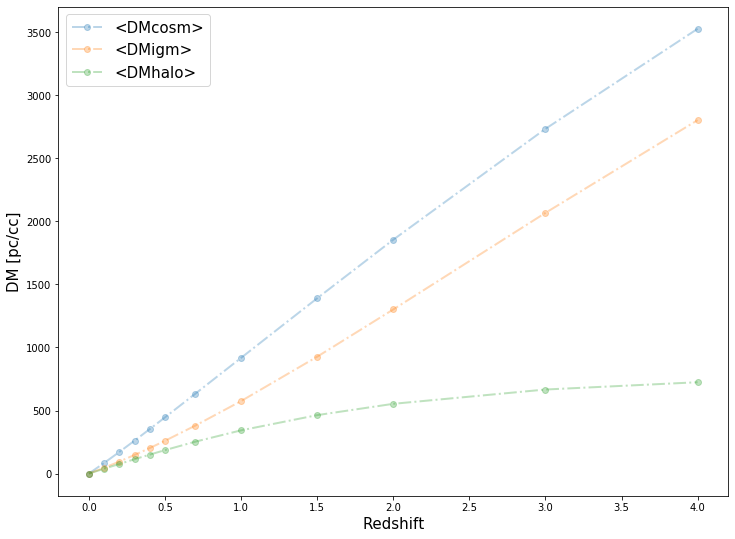

In [4]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

plt.legend(fontsize=15)
plt.show()


# Load pipe dDM/dz values

In [5]:
#############################
#Identify files to be loaded#
#############################
#simulation to load data for
sim_to_load = 'TNG100-2'


#all files
all_files = os.listdir('.')

#.npy files
npy_files = [i for i in all_files if '.npy' in i]

#ddmdz files
dDMdz_files = [i for i in npy_files if 'dDMdz_Output' in i]

#correct simulation
dDMdz_files = [i for i in npy_files if sim_to_load in i]

#list of snapshots wth data
snap_list = [int(i.split('_')[3]) for i in dDMdz_files]

#sort into ascending order
dDMdz_files = [x for _, x in sorted(zip(snap_list, dDMdz_files))]
snap_list.sort()

#reverse into descending order
dDMdz_files = dDMdz_files[::-1]
snap_list = snap_list[::-1]

#crop to redshift 5, because that is as far as the theory goes in FRB package.
#Note that after z=3 accuracy 'is not guaranteed'

dDMdz_files = dDMdz_files[0:12]
snap_list = snap_list[0:12]

#print to check
print(snap_list)
print(dDMdz_files)

[99, 99, 91, 91, 84, 84, 78, 78, 72, 72, 67, 67]
['Sim_TNG100-2_Snap_99_dDMdz_Output_pID_test.npy', 'Sim_TNG100-2_Snap_99_dDMdz_Output.npy', 'Sim_TNG100-2_Snap_91_dDMdz_Output_pID_test.npy', 'Sim_TNG100-2_Snap_91_dDMdz_Output.npy', 'Sim_TNG100-2_Snap_84_dDMdz_Output_pID_test.npy', 'Sim_TNG100-2_Snap_84_dDMdz_Output.npy', 'Sim_TNG100-2_Snap_78_dDMdz_Output_pID_test.npy', 'Sim_TNG100-2_Snap_78_dDMdz_Output.npy', 'Sim_TNG100-2_Snap_72_dDMdz_Output_pID_test.npy', 'Sim_TNG100-2_Snap_72_dDMdz_Output.npy', 'Sim_TNG100-2_Snap_67_dDMdz_Output_pID_test.npy', 'Sim_TNG100-2_Snap_67_dDMdz_Output.npy']


In [11]:
#############################
#Zhang method initialisation#
#############################

dDMdz_dict_Zhang = {} #initialise dictionary to hold dDMdz values
dDMdz_HaloDict_Zhang = {} #initialise dictionary to hold the halo dDMdz portion
dDMdz_FilaDict_Zhang = {} #initialise dictionary to hold the filament dDMdz portion
dDMdz_VoidDict_Zhang = {} #initialise dictionary to hold the void dDMdz portion

halo_dict_Zhang  = {} #initialise dictionary to hold number of halo cells
fila_dict_Zhang  = {} #initialise dictionary to hold number of filament cells
void_dict_Zhang  = {} #initialise dictionary to hold number of void cells

##################################
#Pakmor Correction initialisation#
##################################

dDMdz_dict_Pakmor = {} #initialise dictionary to hold dDMdz values
dDMdz_HaloDict_Pakmor = {} #initialise dictionary to hold the halo dDMdz portion
dDMdz_FilaDict_Pakmor = {} #initialise dictionary to hold the filament dDMdz portion
dDMdz_VoidDict_Pakmor = {} #initialise dictionary to hold the void dDMdz portion

halo_dict_Pakmor  = {} #initialise dictionary to hold number of halo cells
fila_dict_Pakmor  = {} #initialise dictionary to hold number of filament cells
void_dict_Pakmor  = {} #initialise dictionary to hold number of void cells

######################
#Other initialisation#
######################

snap_redshifts = {} #initialise dictionary to hold redshifts of snapshots
snap_z_list = [] #initialise an array to hold these redshift values for plotting

#######################################
#load the files into a data dictionary#
#######################################

#path to data
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
for i in range(len(dDMdz_files)):#loop over files

    #load and extract dats
    snapshot = dDMdz_files[i].split('_')[3] #extract snapshot number
    
    vals = np.load(dDMdz_files[i],allow_pickle=True).tolist() #extract values from file
    
    dDMdz_dict_Zhang[snapshot]=vals['dDMdz_Zhang']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key
    dDMdz_dict_Pakmor[snapshot]=vals['dDMdz_Pakmor']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key

    dDMdz_HaloDict_Zhang[snapshot]=vals['dDMdzHalo_Zhang']*u.pc*u.cm**-3 #do same for halo portion
    dDMdz_HaloDict_Pakmor[snapshot]=vals['dDMdzHalo_Pakmor']*u.pc*u.cm**-3 #do same for halo portion

    dDMdz_FilaDict_Zhang[snapshot]=vals['dDMdzFilament_Zhang']*u.pc*u.cm**-3 #do same for filament portion
    dDMdz_FilaDict_Pakmor[snapshot]=vals['dDMdzFilament_Pakmor']*u.pc*u.cm**-3 #do same for filament portion

    dDMdz_VoidDict_Zhang[snapshot]=vals['dDMdzVoid_Zhang']*u.pc*u.cm**-3 #do same for void portion
    dDMdz_VoidDict_Pakmor[snapshot]=vals['dDMdzVoid_Pakmor']*u.pc*u.cm**-3 #do same for void portion

    halo_dict_Zhang[snapshot]=np.array(vals['nHalo_Zhang']) #append number of halo cells to dictionary with snapshot number as key
    halo_dict_Pakmor[snapshot]=np.array(vals['nHalo_Pakmor']) #append number of halo cells to dictionary with snapshot number as key

    fila_dict_Zhang[snapshot]=np.array(vals['nFilament_Zhang']) #append number of filament cells to dictionary with snapshot number as key
    fila_dict_Pakmor[snapshot]=np.array(vals['nFilament_Pakmor']) #append number of filament cells to dictionary with snapshot number as key

    void_dict_Zhang[snapshot]=np.array(vals['nVoid_Zhang']) #append number of void cells to dictionary with snapshot number as key
    void_dict_Pakmor[snapshot]=np.array(vals['nVoid_Pakmor']) #append number of void cells to dictionary with snapshot number as key
 

    header = il.groupcat.loadHeader(basePath,int(snapshot)) #extract simulation and snapshot header
    snap_redshifts[snapshot]=header['Redshift'] #get redshift at this snapshot
    snap_z_list.append(header['Redshift']) #append to array


print(snap_redshifts['99'])    

print('totals: {0} ({1})'.format(dDMdz_dict_Zhang['99'],dDMdz_dict_Pakmor['99']))
print('sum of structures: {0} ({1})'.format(dDMdz_HaloDict_Zhang['99']+dDMdz_FilaDict_Zhang['99']+dDMdz_VoidDict_Zhang['99'],
                                            dDMdz_HaloDict_Pakmor['99']+dDMdz_FilaDict_Pakmor['99']+dDMdz_VoidDict_Pakmor['99']))
print(halo_dict_Zhang['99'])
print(halo_dict_Zhang['99']+fila_dict_Zhang['99']+void_dict_Zhang['99'])
print(len(snap_redshifts))

print(halo_dict_Zhang)

print(len(halo_dict_Zhang['99']),len(halo_dict_Zhang['91']))

2.220446049250313e-16
totals: [ 228.82109959 1022.71088408 1039.75694126 ...  282.09357087 1493.83935089
  456.10828073] pc / cm3 ([ 228.82109925 1022.71088527 1039.75693967 ...  282.0935717  1493.83935123
  456.1082826 ] pc / cm3)
sum of structures: [ 228.82109959 1022.71088408 1039.75694126 ...  282.09357087 1493.83935089
  456.10828073] pc / cm3 ([ 228.8210996  1022.71088536 1039.75693958 ...  282.0935714  1493.83935089
  456.10828253] pc / cm3)
[ 0  0  3 ...  0 44  0]
[10000 10000 10000 ... 10000 10000 10000]
6
{'99': array([ 0,  0,  3, ...,  0, 44,  0]), '91': array([  0,   0,   0, ...,   0, 198,   0]), '84': array([42,  0,  7, ...,  0,  4,  7]), '78': array([0, 4, 0, ..., 0, 0, 0]), '72': array([30, 34,  0, ...,  0,  0,  0]), '67': array([ 0,  2,  6, ...,  0, 62,  0])}
5125 5125


# Calculate total DM for a single line of sight,
# Calculate LSS DM values for this line of sight
# Also extract LSS cell details

In [12]:
#calculate DMIGM(z) for a single line of sight according to paper

############
#Initialise#
############

x = snap_list

DMIGM_Zhang     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0
DMIGM_Pakmor     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0

DMIGM_Halo_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only halo portion of DM
DMIGM_Halo_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only halo portion of DM

DMIGM_Fila_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only filament portion of DM
DMIGM_Fila_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only filament portion of DM

DMIGM_Void_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only void portion of DM
DMIGM_Void_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only void portion of DM

HaloCells_Zhang = [0.] #initialise arrays to store the number of halo cells for the created LoS
HaloCells_Pakmor = [0.] #initialise arrays to store the number of halo cells for the created LoS

FilaCells_Zhang = [0.] #initialise arrays to store the number of filament cells for the created LoS
FilaCells_Pakmor = [0.] #initialise arrays to store the number of filament cells for the created LoS

VoidCells_Zhang = [0.] #initialise arrays to store the number of void cells for the created LoS
VoidCells_Pakmor = [0.] #initialise arrays to store the number of void cells for the created LoS

#####################
#loop over snapshots#
#####################

for i in range(len(x)-1): 
    
    print(i)
    #get snapshot number for this snapshot
    snap_id = str(snap_list[i])
    #get snapshot number for next snapshot
    snap_id_ = str(snap_list[i+1])
    print(snap_id,snap_id_)
    #get this snapshot redshift
    snap_z = snap_redshifts[snap_id]
    #get next snapshot redshift
    snap_z_ = snap_redshifts[snap_id_]
    print(snap_z,snap_z_)
    
    ##############################################################
    #randomly select dDM/dz and LSS cell values for this redshift#
    ##############################################################
    
    #######
    #Zhang#
    #######
    
    #select the pipe
    rand_idx_Zhang = np.random.choice(np.arange(len(dDMdz_dict_Zhang[snap_id])))
    print(rand_idx_Zhang)
    #get the dDMdz values
    rand_dDMdz_Zhang = dDMdz_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Halo_Zhang = dDMdz_HaloDict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Fila_Zhang = dDMdz_FilaDict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Void_Zhang = dDMdz_VoidDict_Zhang[snap_id][rand_idx_Zhang]
    #get the cell values
    rand_nHalo_Zhang = halo_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_nFila_Zhang = fila_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_nVoid_Zhang = void_dict_Zhang[snap_id][rand_idx_Zhang]
    print('For Snapshot {0}'.format(snap_id))
    print('The random Zhang id is {0}'.format(rand_idx_Zhang))
    print('dDM/dz Zhang values are',rand_dDMdz_Zhang,rand_dDMdz_Halo_Zhang+rand_dDMdz_Fila_Zhang+rand_dDMdz_Void_Zhang)
    print('cell values are',rand_nHalo_Zhang,rand_nFila_Zhang,rand_nVoid_Zhang)

    ########
    #Pakmor#
    ########
    
    #select the pipe
    rand_idx_Pakmor = np.random.choice(np.arange(len(dDMdz_dict_Pakmor[snap_id])))
    print(rand_idx_Pakmor)
    #get the dDMdz values
    rand_dDMdz_Pakmor = dDMdz_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Halo_Pakmor = dDMdz_HaloDict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Fila_Pakmor = dDMdz_FilaDict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Void_Pakmor = dDMdz_VoidDict_Pakmor[snap_id][rand_idx_Pakmor]
    #get the cell values
    rand_nHalo_Pakmor = halo_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_nFila_Pakmor = fila_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_nVoid_Pakmor = void_dict_Pakmor[snap_id][rand_idx_Pakmor]
    print('The random Pakmor id is {0}'.format(rand_idx_Pakmor))
    print('dDM/dz Pakmor values are',rand_dDMdz_Pakmor,rand_dDMdz_Halo_Pakmor+rand_dDMdz_Fila_Pakmor+rand_dDMdz_Void_Pakmor)    
    print('cell values are',rand_nHalo_Pakmor,rand_nFila_Pakmor,rand_nVoid_Pakmor)
    
    
    ##############################################################
    #randomly select dDM/dz and LSS cell values for next redshift#
    ##############################################################
    
    #######
    #Zhang#
    #######
    
    #select the pipe
    rand_idx_Zhang_ = np.random.choice(np.arange(len(dDMdz_dict_Zhang[snap_id_])))   
    #get the dDMdz values
    rand_dDMdz_Zhang_ = dDMdz_dict_Zhang[snap_id_][rand_idx_Zhang_]    
    rand_dDMdz_Halo_Zhang_ = dDMdz_HaloDict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_dDMdz_Fila_Zhang_ = dDMdz_FilaDict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_dDMdz_Void_Zhang_ = dDMdz_VoidDict_Zhang[snap_id_][rand_idx_Zhang_]
    #get the cell values
    rand_nHalo_Zhang_ = halo_dict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_nFila_Zhang_ = fila_dict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_nVoid_Zhang_ = void_dict_Zhang[snap_id_][rand_idx_Zhang_]
    print('For next redshift ({0}):'.format(snap_id_))
    print('The random Zhang id is {0}'.format(rand_idx_Zhang_))    
    print('Ddm/dz Zhang values are',rand_dDMdz_Zhang_,rand_dDMdz_Halo_Zhang_+rand_dDMdz_Fila_Zhang_+rand_dDMdz_Void_Zhang_)
    print('cell values',rand_nHalo_Zhang_,rand_nFila_Zhang_,rand_nVoid_Zhang_)

    ########
    #Pakmor#
    ########
    
    #select the pipe
    rand_idx_Pakmor_ = np.random.choice(np.arange(len(dDMdz_dict_Pakmor[snap_id_])))   
    #get the dDMdz values
    rand_dDMdz_Pakmor_ = dDMdz_dict_Pakmor[snap_id_][rand_idx_Pakmor_]    
    rand_dDMdz_Halo_Pakmor_ = dDMdz_HaloDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_dDMdz_Fila_Pakmor_ = dDMdz_FilaDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_dDMdz_Void_Pakmor_ = dDMdz_VoidDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    #get the cell values
    rand_nHalo_Pakmor_ = halo_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_nFila_Pakmor_ = fila_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_nVoid_Pakmor_ = void_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    print('The random Pakmor id is {0}'.format(rand_idx_Pakmor_))
    print('dDM/dz Pakmor values are',rand_dDMdz_Pakmor_,rand_dDMdz_Halo_Pakmor_+rand_dDMdz_Fila_Pakmor_+rand_dDMdz_Void_Pakmor_)
    print('cell values are',rand_nHalo_Pakmor_,rand_nFila_Pakmor_,rand_nVoid_Pakmor_)
    
    ######################
    #create the DM values#
    ######################
    
    nextDM_Zhang     = DMIGM_Zhang[i] + ((0.5*(rand_dDMdz_Zhang+rand_dDMdz_Zhang_)) * (snap_z_ -  snap_z))
    nextDM_Pakmor     = DMIGM_Pakmor[i] + ((0.5*(rand_dDMdz_Pakmor+rand_dDMdz_Pakmor_)) * (snap_z_ -  snap_z))

    nextHaloDM_Zhang = DMIGM_Halo_Zhang[i] + ((0.5*(rand_dDMdz_Halo_Zhang+rand_dDMdz_Halo_Zhang_)) * (snap_z_ -  snap_z))
    nextHaloDM_Pakmor = DMIGM_Halo_Pakmor[i] + ((0.5*(rand_dDMdz_Halo_Pakmor+rand_dDMdz_Halo_Pakmor_)) * (snap_z_ -  snap_z))

    nextFilaDM_Zhang = DMIGM_Fila_Zhang[i] + ((0.5*(rand_dDMdz_Fila_Zhang+rand_dDMdz_Fila_Zhang_)) * (snap_z_ -  snap_z))
    nextFilaDM_Pakmor = DMIGM_Fila_Pakmor[i] + ((0.5*(rand_dDMdz_Fila_Pakmor+rand_dDMdz_Fila_Pakmor_)) * (snap_z_ -  snap_z))

    nextVoidDM_Zhang = DMIGM_Void_Zhang[i] + ((0.5*(rand_dDMdz_Void_Zhang+rand_dDMdz_Void_Zhang_)) * (snap_z_ -  snap_z))
    nextVoidDM_Pakmor = DMIGM_Void_Pakmor[i] + ((0.5*(rand_dDMdz_Void_Pakmor+rand_dDMdz_Void_Pakmor_)) * (snap_z_ -  snap_z))
    
    ################################################################################
    #create the number of LSS cell value by averaging those of the two chosen pipes#
    ################################################################################
    
    nextHalo_Zhang = (0.5*(rand_nHalo_Zhang+rand_nHalo_Zhang_))
    nextHalo_Pakmor = (0.5*(rand_nHalo_Pakmor+rand_nHalo_Pakmor_))

    nextFila_Zhang = (0.5*(rand_nFila_Zhang+rand_nFila_Zhang_))
    nextFila_Pakmor = (0.5*(rand_nFila_Pakmor+rand_nFila_Pakmor_))
    
    nextVoid_Zhang = (0.5*(rand_nVoid_Zhang+rand_nVoid_Zhang_))
    nextVoid_Pakmor = (0.5*(rand_nVoid_Pakmor+rand_nVoid_Pakmor_))
    
    ##################
    #Append to arrays#
    ##################
    
    DMIGM_Zhang.append(nextDM_Zhang)
    DMIGM_Pakmor.append(nextDM_Pakmor)
    
    DMIGM_Halo_Zhang.append(nextHaloDM_Zhang)
    DMIGM_Halo_Pakmor.append(nextHaloDM_Pakmor)

    DMIGM_Fila_Zhang.append(nextFilaDM_Zhang)
    DMIGM_Fila_Pakmor.append(nextFilaDM_Pakmor)

    DMIGM_Void_Zhang.append(nextVoidDM_Zhang)
    DMIGM_Void_Pakmor.append(nextVoidDM_Pakmor)
    
    HaloCells_Zhang.append(nextHalo_Zhang)
    HaloCells_Pakmor.append(nextHalo_Pakmor)

    FilaCells_Zhang.append(nextFila_Zhang)
    FilaCells_Pakmor.append(nextFila_Pakmor)

    VoidCells_Zhang.append(nextVoid_Zhang)
    VoidCells_Pakmor.append(nextVoid_Pakmor)
    
#################################################
#create the fractions of LSS cells at each point#
#################################################

fraction_Halo_Zhang = np.array(HaloCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Halo_Pakmor = np.array(HaloCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

fraction_Fila_Zhang = np.array(FilaCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Fila_Pakmor = np.array(FilaCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

fraction_Void_Zhang = np.array(VoidCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Void_Pakmor = np.array(VoidCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

#########################
#Convert to numpy arrays#
#########################

DMIGM_Zhang = np.array(DMIGM_Zhang)
DMIGM_Pakmor = np.array(DMIGM_Pakmor)

DMIGM_Halo_Zhang = np.array(DMIGM_Halo_Zhang)
DMIGM_Halo_Pakmor = np.array(DMIGM_Halo_Pakmor)

DMIGM_Fila_Zhang = np.array(DMIGM_Fila_Zhang)
DMIGM_Fila_Pakmor = np.array(DMIGM_Fila_Pakmor)

DMIGM_Void_Zhang = np.array(DMIGM_Void_Zhang)
DMIGM_Void_Pakmor = np.array(DMIGM_Void_Pakmor)

print(' tests')
print(len(x),len(DMIGM_Zhang))
print(HaloCells_Zhang)
print('DM_tests')
print(DMIGM_Zhang,DMIGM_Halo_Zhang+DMIGM_Fila_Zhang+DMIGM_Void_Zhang)
print('fracion tests')
print(fraction_Halo_Zhang)
print(fraction_Fila_Zhang)
print(fraction_Void_Zhang)
print(fraction_Halo_Zhang+fraction_Fila_Zhang+fraction_Void_Zhang)

0
99 99
2.220446049250313e-16 2.220446049250313e-16
3335
For Snapshot 99
The random Zhang id is 3335
dDM/dz Zhang values are 819.9037790569258 pc / cm3 819.9037790569259 pc / cm3
cell values are 3 2104 7893
1998
The random Pakmor id is 1998
dDM/dz Pakmor values are 537.0189030675041 pc / cm3 537.018902981343 pc / cm3
cell values are 0 1919 8081
For next redshift (99):
The random Zhang id is 1215
Ddm/dz Zhang values are 205.82468259534141 pc / cm3 205.82468259534141 pc / cm3
cell values 0 1020 8980
The random Pakmor id is 2643
dDM/dz Pakmor values are 495.30879351412943 pc / cm3 495.3087932904972 pc / cm3
cell values are 0 2006 7994
1
99 91
2.220446049250313e-16 0.09940180263022191
5023
For Snapshot 99
The random Zhang id is 5023
dDM/dz Zhang values are 548.0610347258468 pc / cm3 548.0610347258468 pc / cm3
cell values are 0 1522 8478
315
The random Pakmor id is 315
dDM/dz Pakmor values are 1235.0477042372559 pc / cm3 1235.0477041591485 pc / cm3
cell values are 0 2198 7802
For next redsh

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:202: RuntimeWarning: invalid value encountered in true_divide


# Note: the below code will plot number fractions wrong until the data is fixed

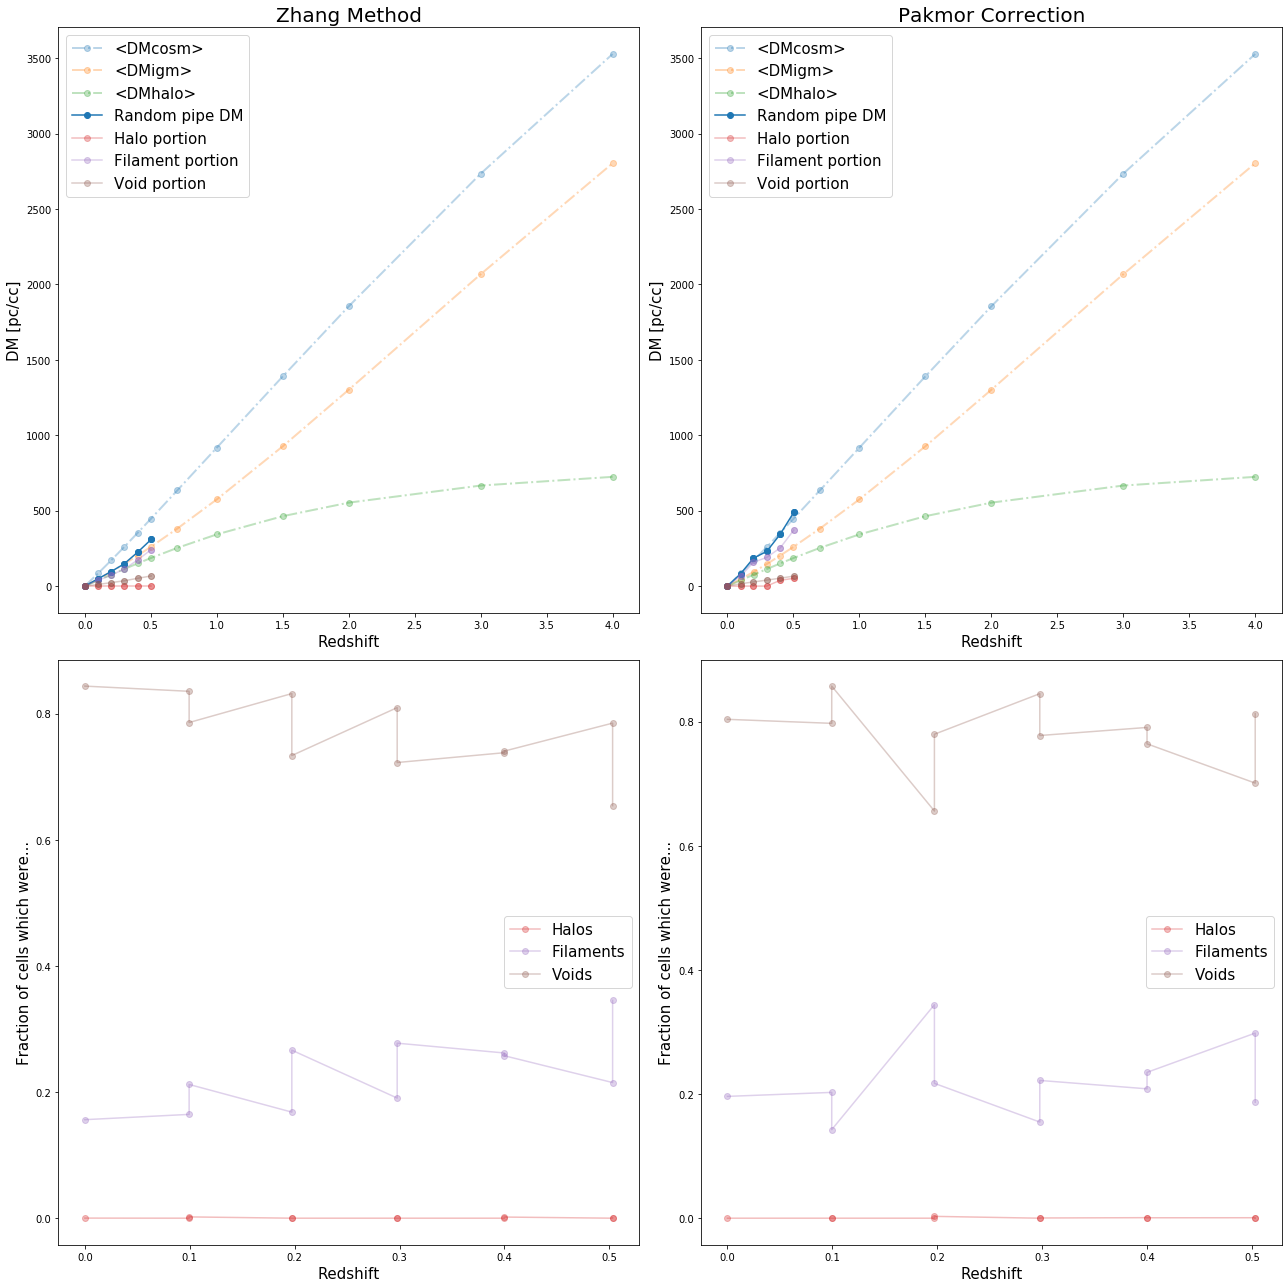

[    nan 0.1562  0.1646  0.21205 0.1682  0.26645 0.19045 0.2775  0.26195
 0.25755 0.21505 0.3453 ] [    nan 0.19625 0.2027  0.1427  0.34395 0.2173  0.1549  0.22195 0.20845
 0.235   0.29825 0.1869 ]


In [13]:
##########################################
#plot single line of sight for quick test#
##########################################

#################
#initialise plot#
#################
fig = plt.figure(figsize=(18,18))

ax1 = fig.add_subplot(221)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM [pc/cc]',fontsize=15)

ax2 = fig.add_subplot(222)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM [pc/cc]',fontsize=15)

ax3 = fig.add_subplot(223)
ax3.set_xlabel('Redshift',fontsize=15)
ax3.set_ylabel('Fraction of cells which were...',fontsize=15)

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Redshift',fontsize=15)
ax4.set_ylabel('Fraction of cells which were...',fontsize=15)

#################
#plot the theory#
#################

ax1.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax1.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax1.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax2.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax2.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax2.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

##############
#plot the los#
##############

ax1.plot(snap_z_list,DMIGM_Zhang,marker='o',label='Random pipe DM')
ax1.plot(snap_z_list,DMIGM_Halo_Zhang,marker='o',color='C3',alpha=0.3,label='Halo portion')
ax1.plot(snap_z_list,DMIGM_Fila_Zhang,marker='o',color='C4',alpha=0.3,label='Filament portion')
ax1.plot(snap_z_list,DMIGM_Void_Zhang,marker='o',color='C5',alpha=0.3,label='Void portion')
ax1.legend(fontsize=15)

ax2.plot(snap_z_list,DMIGM_Pakmor,marker='o',label='Random pipe DM')
ax2.plot(snap_z_list,DMIGM_Halo_Pakmor,marker='o',color='C3',alpha=0.3,label='Halo portion')
ax2.plot(snap_z_list,DMIGM_Fila_Pakmor,marker='o',color='C4',alpha=0.3,label='Filament portion')
ax2.plot(snap_z_list,DMIGM_Void_Pakmor,marker='o',color='C5',alpha=0.3,label='Void portion')
ax2.legend(fontsize=15)

################
#plot fractions#
################

ax3.plot(snap_z_list,fraction_Halo_Zhang,marker='o',color='C3',alpha=0.3,label='Halos')
ax3.plot(snap_z_list,fraction_Fila_Zhang,marker='o',color='C4',alpha=0.3,label='Filaments')
ax3.plot(snap_z_list,fraction_Void_Zhang,marker='o',color='C5',alpha=0.3,label='Voids')
ax3.legend(fontsize=15)

ax4.plot(snap_z_list,fraction_Halo_Pakmor,marker='o',color='C3',alpha=0.3,label='Halos')
ax4.plot(snap_z_list,fraction_Fila_Pakmor,marker='o',color='C4',alpha=0.3,label='Filaments')
ax4.plot(snap_z_list,fraction_Void_Pakmor,marker='o',color='C5',alpha=0.3,label='Voids')
ax4.legend(fontsize=15)

plt.tight_layout()
plt.savefig('{0}_Single_LoS_Analysis.png'.format(sim_to_load),format='png')
plt.show()

print(fraction_Fila_Zhang,fraction_Fila_Pakmor)

# Calculate DM for many lines of sight

## creating array of cDM for many sightlines

In [14]:
nlos = 10000000 #number of lines of sight

################################################
#create an array of randomly drawn dDMdz values#
################################################

########################################################################
#array of randomly generated indices to select pipes from each snapshot#
########################################################################

idx_arr_Zhang  = np.array([np.random.choice(np.arange(len(dDMdz_dict_Zhang[str(snap_id)])),size=nlos) for snap_id in snap_list])
idx_arr_Pakmor = np.array([np.random.choice(np.arange(len(dDMdz_dict_Pakmor[str(snap_id)])),size=nlos) for snap_id in snap_list])

#################################
#the dDMdz values of these pipes#
#################################

dDMdz_arr_Zhang  = np.array([dDMdz_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_arr_Pakmor = np.array([dDMdz_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

###################################################
#the halo, filament and void values of these pipes#
###################################################

dDMdz_HaloArr_Zhang = np.array([dDMdz_HaloDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_HaloArr_Pakmor = np.array([dDMdz_HaloDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

dDMdz_FilaArr_Zhang = np.array([dDMdz_FilaDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_FilaArr_Pakmor = np.array([dDMdz_FilaDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

dDMdz_VoidArr_Zhang = np.array([dDMdz_VoidDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_VoidArr_Pakmor = np.array([dDMdz_VoidDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

print('check: the difference between the totals and the sum of the structures should be zero')
print(np.sum(dDMdz_arr_Zhang - (dDMdz_HaloArr_Zhang+dDMdz_FilaArr_Zhang+dDMdz_VoidArr_Zhang)))
print(np.sum(dDMdz_arr_Pakmor - (dDMdz_HaloArr_Pakmor+dDMdz_FilaArr_Pakmor+dDMdz_VoidArr_Pakmor)))

#############################
#also extract arrays for LSS#
#############################

#the number of halo cells which made this pipe
los_Halo_arr_Zhang  = np.array([halo_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Halo_arr_Pakmor = np.array([halo_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

#the number of filament cells which made this pipe
los_Fila_arr_Zhang  = np.array([fila_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Fila_arr_Pakmor = np.array([fila_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

#the number of void cells which made this pipe
los_Void_arr_Zhang  = np.array([void_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Void_arr_Pakmor = np.array([void_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

###########################
#create array of redshifts#
###########################

z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

####################################################
#perform the calculation to get DM at each redshift#
####################################################

DM_arr_Zhang  = (0.5*(dDMdz_arr_Zhang[:,:][0:-1]+dDMdz_arr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #total
DM_arr_Pakmor = (0.5*(dDMdz_arr_Pakmor[:,:][0:-1]+dDMdz_arr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #total

DM_HaloArr_Zhang  = (0.5*(dDMdz_HaloArr_Zhang[:,:][0:-1]+dDMdz_HaloArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #halos
DM_HaloArr_Pakmor = (0.5*(dDMdz_HaloArr_Pakmor[:,:][0:-1]+dDMdz_HaloArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #halos

DM_FilaArr_Zhang  = (0.5*(dDMdz_FilaArr_Zhang[:,:][0:-1]+dDMdz_FilaArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #filaments
DM_FilaArr_Pakmor = (0.5*(dDMdz_FilaArr_Pakmor[:,:][0:-1]+dDMdz_FilaArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #filaments

DM_VoidArr_Zhang  = (0.5*(dDMdz_VoidArr_Zhang[:,:][0:-1]+dDMdz_VoidArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #voids
DM_VoidArr_Pakmor = (0.5*(dDMdz_VoidArr_Pakmor[:,:][0:-1]+dDMdz_VoidArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #voids

######################################################################
#perform the calculation to get the average LSS data at each redshift#
######################################################################

av_Hal_arr_Zhang  = (0.5*(los_Halo_arr_Zhang[:,:][0:-1]+los_Halo_arr_Zhang[:,:][1:]))
av_Hal_arr_Pakmor = (0.5*(los_Halo_arr_Pakmor[:,:][0:-1]+los_Halo_arr_Pakmor[:,:][1:]))

av_Fil_arr_Zhang  = (0.5*(los_Fila_arr_Zhang[:,:][0:-1]+los_Fila_arr_Zhang[:,:][1:]))
av_Fil_arr_Pakmor = (0.5*(los_Fila_arr_Pakmor[:,:][0:-1]+los_Fila_arr_Pakmor[:,:][1:]))

av_Voi_arr_Zhang  = (0.5*(los_Void_arr_Zhang[:,:][0:-1]+los_Void_arr_Zhang[:,:][1:]))
av_Voi_arr_Pakmor = (0.5*(los_Void_arr_Pakmor[:,:][0:-1]+los_Void_arr_Pakmor[:,:][1:]))

print('check: the sum of these should be 10,000 for every pipe at every z\n',
      'Zhang',
       av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang,
       np.mean(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang),
      'Pakmor',
       av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor,
       np.mean(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor))

##############################################################################
#perform the calculation to turn these into fractions of LSS at each redshift#
##############################################################################

frac_Hal_arr_Zhang  = av_Hal_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Hal_arr_Pakmor = av_Hal_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

frac_Fil_arr_Zhang  = av_Fil_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Fil_arr_Pakmor = av_Fil_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

frac_Voi_arr_Zhang  = av_Voi_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Voi_arr_Pakmor = av_Voi_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

print('check: the sum of these should be 1 for every pipe at every z\n',
      'Zhang',
      frac_Hal_arr_Zhang+frac_Fil_arr_Zhang+frac_Voi_arr_Zhang,
      np.sum((frac_Hal_arr_Zhang+frac_Fil_arr_Zhang+frac_Voi_arr_Zhang),axis=0),
      'Pakmor',
      frac_Hal_arr_Pakmor+frac_Fil_arr_Pakmor+frac_Voi_arr_Pakmor,
      np.sum((frac_Hal_arr_Pakmor+frac_Fil_arr_Pakmor+frac_Voi_arr_Pakmor),axis=0))

#######################################
#add the initial condition of DM=0@z=0#
#######################################

#DMs
DM_arr_Zhang      = np.insert(DM_arr_Zhang,0,np.zeros(nlos),axis=0)
DM_arr_Pakmor     = np.insert(DM_arr_Pakmor,0,np.zeros(nlos),axis=0)

Hal_DM_arr_Zhang  = np.insert(DM_HaloArr_Zhang,0,np.zeros(nlos),axis=0)
Hal_DM_arr_Pakmor = np.insert(DM_HaloArr_Pakmor,0,np.zeros(nlos),axis=0)

Fil_DM_arr_Zhang  = np.insert(DM_FilaArr_Zhang,0,np.zeros(nlos),axis=0)
Fil_DM_arr_Pakmor = np.insert(DM_FilaArr_Pakmor,0,np.zeros(nlos),axis=0)

Voi_DM_arr_Zhang  = np.insert(DM_VoidArr_Zhang,0,np.zeros(nlos),axis=0)
Voi_DM_arr_Pakmor = np.insert(DM_VoidArr_Pakmor,0,np.zeros(nlos),axis=0)

#number fractions
frac_Hal_arr_Zhang  = np.insert(frac_Hal_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Hal_arr_Pakmor = np.insert(frac_Hal_arr_Pakmor,0,np.zeros(nlos),axis=0)

frac_Fil_arr_Zhang  = np.insert(frac_Fil_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Fil_arr_Pakmor = np.insert(frac_Fil_arr_Pakmor,0,np.zeros(nlos),axis=0)

frac_Voi_arr_Zhang  = np.insert(frac_Voi_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Voi_arr_Pakmor = np.insert(frac_Voi_arr_Pakmor,0,np.zeros(nlos),axis=0)

print('Zhang check: the DM_arr / the sum of the structures should be 1',DM_arr_Zhang/(Hal_DM_arr_Zhang+Fil_DM_arr_Zhang+Voi_DM_arr_Zhang))
print('Pakmor check: the DM_arr / the sum of the structures should be 1',DM_arr_Pakmor/(Hal_DM_arr_Pakmor+Fil_DM_arr_Pakmor+Voi_DM_arr_Pakmor))

##############################################################
#perform the cumulative sum to get the cDM for each light ray#
##############################################################

cDM_arr_Zhang = np.cumsum(DM_arr_Zhang,axis=0) #total
cDM_arr_Pakmor  = np.cumsum(DM_arr_Pakmor,axis=0) #total

Hal_cDM_arr_Zhang  = np.cumsum(Hal_DM_arr_Zhang,axis=0) #halo
Hal_cDM_arr_Pakmor = np.cumsum(Hal_DM_arr_Pakmor,axis=0) #halo

Fil_cDM_arr_Zhang  = np.cumsum(Fil_DM_arr_Zhang,axis=0) #filament
Fil_cDM_arr_Pakmor = np.cumsum(Fil_DM_arr_Pakmor,axis=0) #filament

Voi_cDM_arr_Zhang  = np.cumsum(Voi_DM_arr_Zhang,axis=0) #void
Voi_cDM_arr_Pakmor = np.cumsum(Voi_DM_arr_Pakmor,axis=0) #void

print('Zhang check: the cDM_arr / the sum of the structures should be 1',cDM_arr_Zhang/(Hal_cDM_arr_Zhang+Fil_cDM_arr_Zhang+Voi_cDM_arr_Zhang))
print('Pakmor check: the cDM_arr / the sum of the structures should be 1',cDM_arr_Pakmor/(Hal_cDM_arr_Pakmor+Fil_cDM_arr_Pakmor+Voi_cDM_arr_Pakmor))


#print(DM_arr)
#print(cDM_arr)
print(cDM_arr_Zhang.shape)
print(cDM_arr_Pakmor.shape)

check: the difference between the totals and the sum of the structures should be zero
9.786066357264644e-08 pc / cm3
-2.0016588823007737 pc / cm3
check: the sum of these should be 10,000 for every pipe at every z
 Zhang [[10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 ...
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]] 10000.0 Pakmor [[10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 ...
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]] 10000.0
check: the sum of these should be 1 for every pipe at every z
 Zhang [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Zhang check: the DM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [nan nan nan ... nan nan nan]]
Pakmor check: the DM_arr / the sum of the structures should be 1 [[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [1.         1.         1.         ... 1.         0.99999999 1.        ]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [       nan        nan        nan ...        nan        nan        nan]]
Zhang check: the cDM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1. 

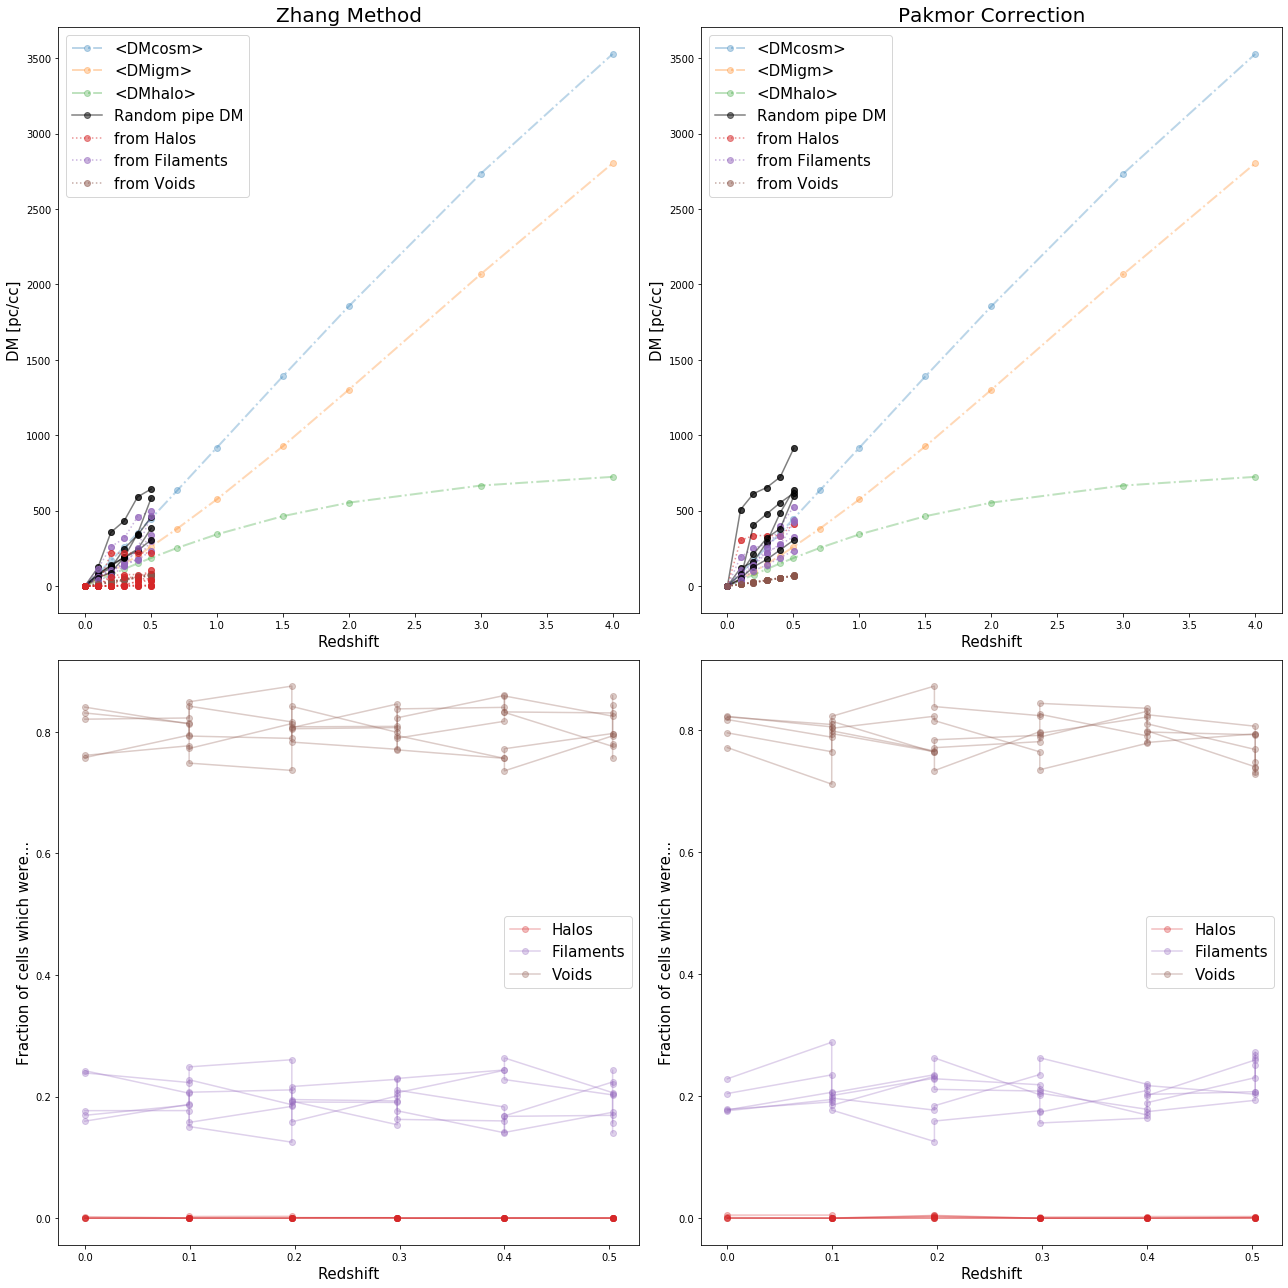

In [15]:
####################
#Initialise figures#
####################

fig = plt.figure(figsize=(18,18))

ax1 = fig.add_subplot(221)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM [pc/cc]',fontsize=15)

ax2 = fig.add_subplot(222)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM [pc/cc]',fontsize=15)

ax3 = fig.add_subplot(223)
ax3.set_xlabel('Redshift',fontsize=15)
ax3.set_ylabel('Fraction of cells which were...',fontsize=15)

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Redshift',fontsize=15)
ax4.set_ylabel('Fraction of cells which were...',fontsize=15)

#################
#plot the theory#
#################

ax1.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax1.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax1.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax2.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax2.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax2.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

##############
#Plot the DMs#
##############

for i in range(5):
    if i==0:
        ax1.plot(snap_z_list,cDM_arr_Zhang[:,i],marker='o',color='k',alpha=0.5,label='Random pipe DM')
        ax1.plot(snap_z_list,Hal_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C3',alpha=0.5,label='from Halos')
        ax1.plot(snap_z_list,Fil_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C4',alpha=0.5,label='from Filaments')
        ax1.plot(snap_z_list,Voi_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C5',alpha=0.5,label='from Voids')

    else:
        ax1.plot(snap_z_list,cDM_arr_Zhang[:,i],marker='o',color='k',alpha=0.5)
        ax1.plot(snap_z_list,Hal_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C3',alpha=0.5)
        ax1.plot(snap_z_list,Fil_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C4',alpha=0.5)
        ax1.plot(snap_z_list,Voi_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C5',alpha=0.5)
ax1.legend(fontsize=15)

for i in range(5):
    if i==0:
        ax2.plot(snap_z_list,cDM_arr_Pakmor[:,i],marker='o',color='k',alpha=0.5,label='Random pipe DM')
        ax2.plot(snap_z_list,Hal_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C3',alpha=0.5,label='from Halos')
        ax2.plot(snap_z_list,Fil_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C4',alpha=0.5,label='from Filaments')
        ax2.plot(snap_z_list,Voi_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C5',alpha=0.5,label='from Voids')

    else:
        ax2.plot(snap_z_list,cDM_arr_Pakmor[:,i],marker='o',color='k',alpha=0.5)
        ax1.plot(snap_z_list,Hal_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C3',alpha=0.5)
        ax2.plot(snap_z_list,Fil_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C4',alpha=0.5)
        ax2.plot(snap_z_list,Voi_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C5',alpha=0.5)
ax2.legend(fontsize=15)

###########################
#Plot the number fractions#
###########################

for i in range(5):
    if i==0:
        ax3.plot(snap_z_list[1:],frac_Hal_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C3',label='Halos')
        ax3.plot(snap_z_list[1:],frac_Fil_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C4',label='Filaments')
        ax3.plot(snap_z_list[1:],frac_Voi_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C5',label='Voids')
    else:
        ax3.plot(snap_z_list[1:],frac_Hal_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C3')
        ax3.plot(snap_z_list[1:],frac_Fil_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C4')
        ax3.plot(snap_z_list[1:],frac_Voi_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C5')
        
ax3.legend(fontsize=15)

for i in range(5):
    if i==0:
        ax4.plot(snap_z_list[1:],frac_Hal_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C3',label='Halos')
        ax4.plot(snap_z_list[1:],frac_Fil_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C4',label='Filaments')
        ax4.plot(snap_z_list[1:],frac_Voi_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C5',label='Voids')
    else:
        ax4.plot(snap_z_list[1:],frac_Hal_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C3')
        ax4.plot(snap_z_list[1:],frac_Fil_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C4')
        ax4.plot(snap_z_list[1:],frac_Voi_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C5')
ax4.legend(fontsize=15)

plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Analysis.png'.format(sim_to_load),format='png')
plt.show()

## get statistics

In [16]:
########
#totals#
########

mean_cDM_arr_Zhang  = np.mean(cDM_arr_Zhang,axis=1) #mean
mean_cDM_arr_Pakmor = np.mean(cDM_arr_Pakmor,axis=1) #mean

medi_cDM_arr_Zhang  = np.median(cDM_arr_Zhang,axis=1) #median
medi_cDM_arr_Pakmor = np.median(cDM_arr_Pakmor,axis=1) #median

stdv_cDM_arr_Zhang  = np.std(cDM_arr_Zhang,axis=1) #standard deviation
stdv_cDM_arr_Pakmor = np.std(cDM_arr_Pakmor,axis=1) #standard deviation

#######
#halos#
#######

mean_Hal_cDM_arr_Zhang  = np.mean(Hal_cDM_arr_Zhang,axis=1) #mean
mean_Hal_cDM_arr_Pakmor = np.mean(Hal_cDM_arr_Pakmor,axis=1) #mean

medi_Hal_cDM_arr_Zhang  = np.median(Hal_cDM_arr_Zhang,axis=1) #median
medi_Hal_cDM_arr_Pakmor = np.median(Hal_cDM_arr_Pakmor,axis=1) #median

stdv_Hal_cDM_arr_Zhang  = np.std(Hal_cDM_arr_Zhang,axis=1) #standard deviation
stdv_Hal_cDM_arr_Pakmor = np.std(Hal_cDM_arr_Pakmor,axis=1) #standard deviation

mean_frac_Hal_arr_Zhang  = np.mean(frac_Hal_arr_Zhang,axis=1) #mean
mean_frac_Hal_arr_Pakmor = np.mean(frac_Hal_arr_Pakmor,axis=1) #mean

medi_frac_Hal_arr_Zhang  = np.median(frac_Hal_arr_Zhang,axis=1) #median
medi_frac_Hal_arr_Pakmor = np.median(frac_Hal_arr_Pakmor,axis=1) #median

stdv_frac_Hal_arr_Zhang  = np.std(frac_Hal_arr_Zhang,axis=1) #standard deviation
stdv_frac_Hal_arr_Pakmor = np.std(frac_Hal_arr_Pakmor,axis=1) #standard deviation

###########
#filaments#
###########

mean_Fil_cDM_arr_Zhang  = np.mean(Fil_cDM_arr_Zhang,axis=1) #mean
mean_Fil_cDM_arr_Pakmor = np.mean(Fil_cDM_arr_Pakmor,axis=1) #mean

medi_Fil_cDM_arr_Zhang  = np.median(Fil_cDM_arr_Zhang,axis=1) #median
medi_Fil_cDM_arr_Pakmor = np.median(Fil_cDM_arr_Pakmor,axis=1) #median

stdv_Fil_cDM_arr_Zhang  = np.std(Fil_cDM_arr_Zhang,axis=1) #standard deviation
stdv_Fil_cDM_arr_Pakmor = np.std(Fil_cDM_arr_Pakmor,axis=1) #standard deviation

mean_frac_Fil_arr_Zhang  = np.mean(frac_Fil_arr_Zhang,axis=1) #mean
mean_frac_Fil_arr_Pakmor = np.mean(frac_Fil_arr_Pakmor,axis=1) #mean

medi_frac_Fil_arr_Zhang  = np.median(frac_Fil_arr_Zhang,axis=1) #median
medi_frac_Fil_arr_Pakmor = np.median(frac_Fil_arr_Pakmor,axis=1) #median

stdv_frac_Fil_arr_Zhang  = np.std(frac_Fil_arr_Zhang,axis=1) #standard deviation
stdv_frac_Fil_arr_Pakmor = np.std(frac_Fil_arr_Pakmor,axis=1) #standard deviation

#######
#voids#
#######

mean_Voi_cDM_arr_Zhang  = np.mean(Voi_cDM_arr_Zhang,axis=1) #mean
mean_Voi_cDM_arr_Pakmor = np.mean(Voi_cDM_arr_Pakmor,axis=1) #mean

medi_Voi_cDM_arr_Zhang  = np.median(Voi_cDM_arr_Zhang,axis=1) #median
medi_Voi_cDM_arr_Pakmor = np.median(Voi_cDM_arr_Pakmor,axis=1) #median

stdv_Voi_cDM_arr_Zhang  = np.std(Voi_cDM_arr_Zhang,axis=1) #standard deviation
stdv_Voi_cDM_arr_Pakmor = np.std(Voi_cDM_arr_Pakmor,axis=1) #standard deviation

mean_frac_Voi_arr_Zhang = np.mean(frac_Voi_arr_Zhang,axis=1) #mean
mean_frac_Voi_arr_Pakmor = np.mean(frac_Voi_arr_Pakmor,axis=1) #mean

medi_frac_Voi_arr_Zhang = np.median(frac_Voi_arr_Zhang,axis=1) #median
medi_frac_Voi_arr_Pakmor = np.median(frac_Voi_arr_Pakmor,axis=1) #median

stdv_frac_Voi_arr_Zhang = np.std(frac_Voi_arr_Zhang,axis=1) #standard deviation
stdv_frac_Voi_arr_Pakmor = np.std(frac_Voi_arr_Pakmor,axis=1) #standard deviation

print('Mean cDM: ',mean_cDM_arr_Zhang,mean_cDM_arr_Pakmor)
print('Median cDM: ',medi_cDM_arr_Zhang,medi_cDM_arr_Pakmor)
print('Standard deviation of cDM: ',stdv_cDM_arr_Zhang, stdv_cDM_arr_Pakmor)

Mean cDM:  [  0.           0.          91.91291016  91.91291016 183.239411
 183.239411   281.55265455 281.55265455 385.60718572 385.60718572
 492.05639339 492.05639339] pc / cm3 [  0.           0.          91.87433163  91.87433163 183.20584475
 183.20584475 281.50740141 281.50740141 385.55014797 385.55014797
 492.03697909 492.03697909] pc / cm3
Median cDM:  [  0.           0.          66.78169651  66.78169651 149.7845138
 149.7845138  242.40834536 242.40834536 341.7791678  341.7791678
 445.07982696 445.07982696] pc / cm3 [  0.           0.          66.80203239  66.80203239 149.75075638
 149.75075638 242.3557002  242.3557002  341.73688993 341.73688993
 445.12957692 445.12957692] pc / cm3
Standard deviation of cDM:  [  0.           0.         108.07764844 108.07764844 136.57169933
 136.57169933 161.51443133 161.51443133 184.67639584 184.67639584
 202.60768065 202.60768065] pc / cm3 [  0.           0.         107.7243982  107.7243982  136.21352779
 136.21352779 161.33756012 161.33756012 1

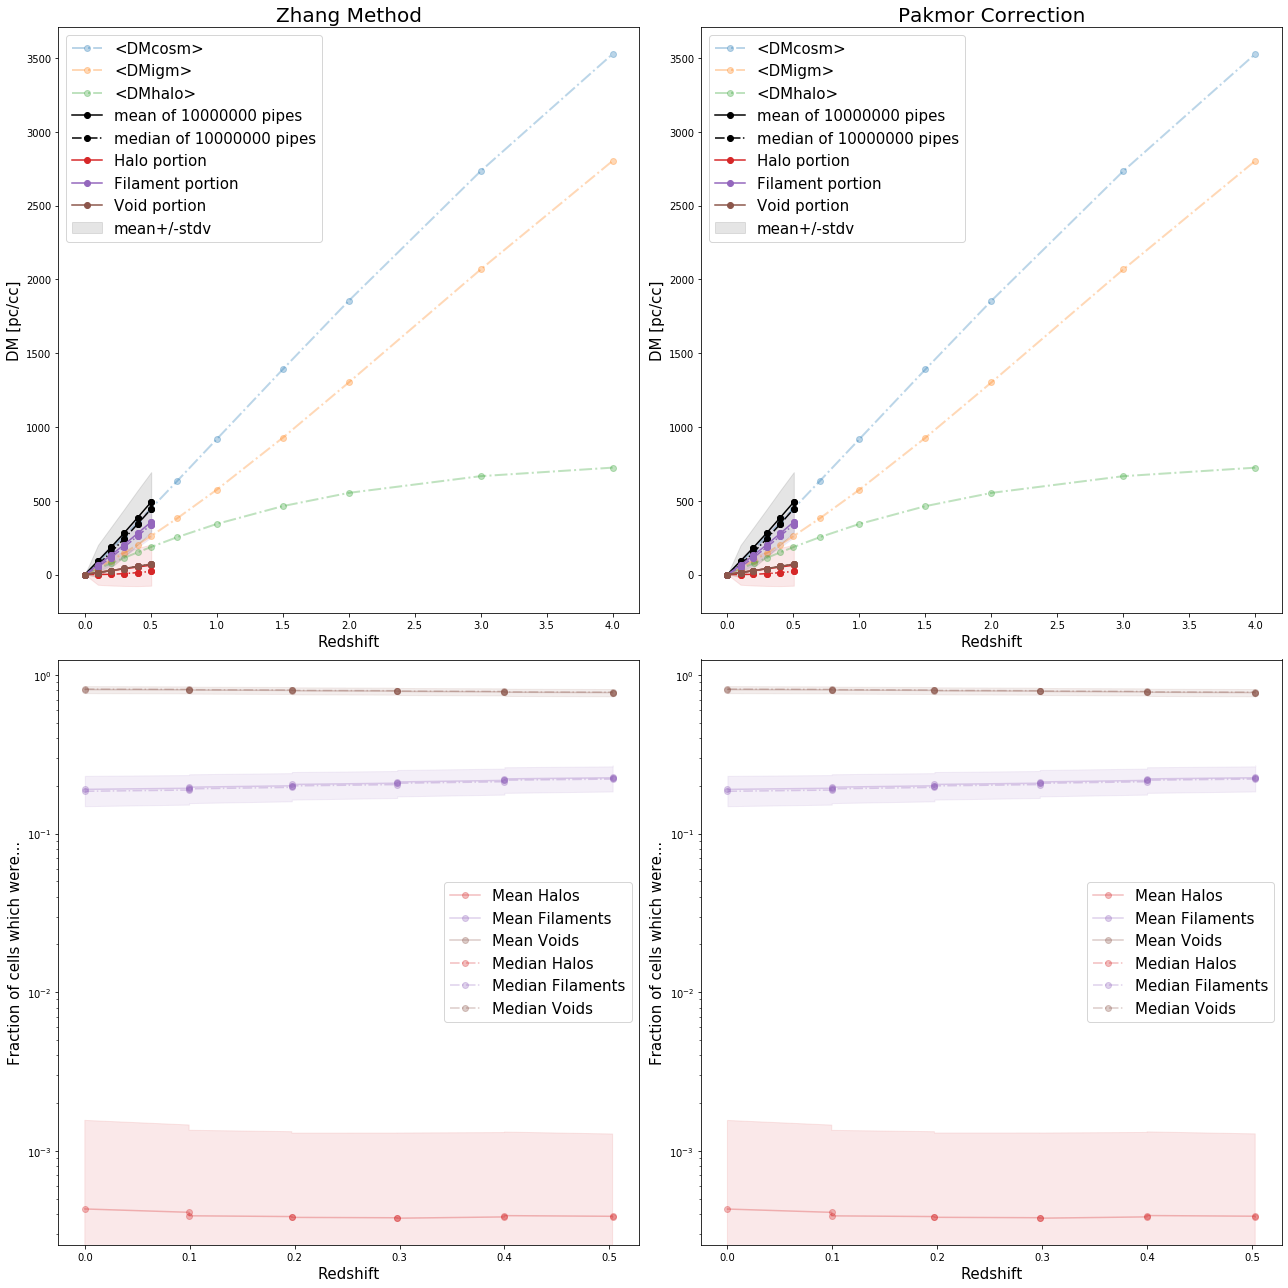

In [17]:
##################
#initialise plots#
##################

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(221)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM [pc/cc]',fontsize=15)

ax2 = fig.add_subplot(222)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM [pc/cc]',fontsize=15)

ax3 = fig.add_subplot(223)
ax3.set_xlabel('Redshift',fontsize=15)
ax3.set_ylabel('Fraction of cells which were...',fontsize=15)
ax3.set_yscale('log')

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Redshift',fontsize=15)
ax4.set_ylabel('Fraction of cells which were...',fontsize=15)
ax4.set_yscale('log')

#############
#Plot theory#
#############

ax1.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax1.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax1.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax1.legend(fontsize=15)


ax2.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax2.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax2.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax1.legend(fontsize=15)

##########
#plot DMs#
##########

#zhang

ax1.plot(snap_z_list,mean_cDM_arr_Zhang,marker='o',color='k',alpha=1,ls='-',label='mean of {0} pipes'.format(cDM_arr_Zhang.shape[1]))
ax1.plot(snap_z_list,medi_cDM_arr_Zhang,marker='o',color='k',alpha=1,ls='-.',label='median of {0} pipes'.format(cDM_arr_Zhang.shape[1]))
ax1.fill_between(snap_z_list,mean_cDM_arr_Zhang+stdv_cDM_arr_Zhang,mean_cDM_arr_Zhang-stdv_cDM_arr_Zhang,alpha=0.1,color='k',label='mean+/-stdv')

ax1.plot(snap_z_list,mean_Hal_cDM_arr_Zhang,marker='o',color='C3',alpha=1,ls='-',label='Halo portion')
ax1.plot(snap_z_list,medi_Hal_cDM_arr_Zhang,marker='o',color='C3',alpha=1,ls='-.')
ax1.fill_between(snap_z_list,mean_Hal_cDM_arr_Zhang+stdv_Hal_cDM_arr_Zhang,mean_Hal_cDM_arr_Zhang-stdv_Hal_cDM_arr_Zhang,alpha=0.1,color='C3')

ax1.plot(snap_z_list,mean_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-',label='Filament portion')
ax1.plot(snap_z_list,medi_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-.')
ax1.fill_between(snap_z_list,mean_Fil_cDM_arr_Zhang+stdv_Fil_cDM_arr_Zhang,mean_Fil_cDM_arr_Zhang-stdv_Fil_cDM_arr_Zhang,alpha=0.1,color='C4')

ax1.plot(snap_z_list,mean_Voi_cDM_arr_Zhang,marker='o',color='C5',alpha=1,ls='-',label='Void portion')
ax1.plot(snap_z_list,medi_Voi_cDM_arr_Zhang,marker='o',color='C5',alpha=1,ls='-.')
ax1.fill_between(snap_z_list,mean_Voi_cDM_arr_Zhang+stdv_Voi_cDM_arr_Zhang,mean_Voi_cDM_arr_Zhang-stdv_Voi_cDM_arr_Zhang,alpha=0.1,color='C5')

ax1.legend(fontsize=15)

#pakmor

ax2.plot(snap_z_list,mean_cDM_arr_Pakmor,marker='o',color='k',alpha=1,ls='-',label='mean of {0} pipes'.format(cDM_arr_Pakmor.shape[1]))
ax2.plot(snap_z_list,medi_cDM_arr_Pakmor,marker='o',color='k',alpha=1,ls='-.',label='median of {0} pipes'.format(cDM_arr_Pakmor.shape[1]))
ax2.fill_between(snap_z_list,mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.1,color='k',label='mean+/-stdv')

ax2.plot(snap_z_list,mean_Hal_cDM_arr_Pakmor,marker='o',color='C3',alpha=1,ls='-',label='Halo portion')
ax2.plot(snap_z_list,medi_Hal_cDM_arr_Pakmor,marker='o',color='C3',alpha=1,ls='-.')
ax2.fill_between(snap_z_list,mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor,mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor,alpha=0.1,color='C3')

ax2.plot(snap_z_list,mean_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-',label='Filament portion')
ax2.plot(snap_z_list,medi_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-.')
ax2.fill_between(snap_z_list,mean_Fil_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor,mean_Fil_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor,alpha=0.1,color='C4')

ax2.plot(snap_z_list,mean_Voi_cDM_arr_Pakmor,marker='o',color='C5',alpha=1,ls='-',label='Void portion')
ax2.plot(snap_z_list,medi_Voi_cDM_arr_Pakmor,marker='o',color='C5',alpha=1,ls='-.')
ax2.fill_between(snap_z_list,mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor,mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor,alpha=0.1,color='C5')

ax2.legend(fontsize=15)

#######################
#plot number fractions#
#######################

#zhang

ax3.plot(snap_z_list[1:],mean_frac_Hal_arr_Zhang[1:],marker='o',alpha=0.3,color='C3',label='Mean Halos')
ax3.plot(snap_z_list[1:],mean_frac_Fil_arr_Zhang[1:],marker='o',alpha=0.3,color='C4',label='Mean Filaments')
ax3.plot(snap_z_list[1:],mean_frac_Voi_arr_Zhang[1:],marker='o',alpha=0.3,color='C5',label='Mean Voids')

ax3.plot(snap_z_list[1:],medi_frac_Hal_arr_Zhang[1:],ls='-.',marker='o',alpha=0.3,color='C3',label='Median Halos')
ax3.plot(snap_z_list[1:],medi_frac_Fil_arr_Zhang[1:],ls='-.',marker='o',alpha=0.3,color='C4',label='Median Filaments')
ax3.plot(snap_z_list[1:],medi_frac_Voi_arr_Zhang[1:],ls='-.',marker='o',alpha=0.3,color='C5',label='Median Voids')

ax3.fill_between(snap_z_list[1:],mean_frac_Hal_arr_Zhang[1:]+stdv_frac_Hal_arr_Zhang[1:],mean_frac_Hal_arr_Zhang[1:]-stdv_frac_Hal_arr_Zhang[1:],alpha=0.1,color='C3')
ax3.fill_between(snap_z_list[1:],mean_frac_Fil_arr_Zhang[1:]+stdv_frac_Fil_arr_Zhang[1:],mean_frac_Fil_arr_Zhang[1:]-stdv_frac_Fil_arr_Zhang[1:],alpha=0.1,color='C4')
ax3.fill_between(snap_z_list[1:],mean_frac_Voi_arr_Zhang[1:]+stdv_frac_Voi_arr_Zhang[1:],mean_frac_Voi_arr_Zhang[1:]-stdv_frac_Voi_arr_Zhang[1:],alpha=0.1,color='C5')

ax3.legend(fontsize=15)


#pakmor

ax4.plot(snap_z_list[1:],mean_frac_Hal_arr_Pakmor[1:],marker='o',alpha=0.3,color='C3',label='Mean Halos')
ax4.plot(snap_z_list[1:],mean_frac_Fil_arr_Pakmor[1:],marker='o',alpha=0.3,color='C4',label='Mean Filaments')
ax4.plot(snap_z_list[1:],mean_frac_Voi_arr_Pakmor[1:],marker='o',alpha=0.3,color='C5',label='Mean Voids')

ax4.plot(snap_z_list[1:],medi_frac_Hal_arr_Pakmor[1:],ls='-.',marker='o',alpha=0.3,color='C3',label='Median Halos')
ax4.plot(snap_z_list[1:],medi_frac_Fil_arr_Pakmor[1:],ls='-.',marker='o',alpha=0.3,color='C4',label='Median Filaments')
ax4.plot(snap_z_list[1:],medi_frac_Voi_arr_Pakmor[1:],ls='-.',marker='o',alpha=0.3,color='C5',label='Median Voids')

ax4.fill_between(snap_z_list[1:],mean_frac_Hal_arr_Pakmor[1:]+stdv_frac_Hal_arr_Pakmor[1:],mean_frac_Hal_arr_Pakmor[1:]-stdv_frac_Hal_arr_Pakmor[1:],alpha=0.1,color='C3')
ax4.fill_between(snap_z_list[1:],mean_frac_Fil_arr_Pakmor[1:]+stdv_frac_Fil_arr_Pakmor[1:],mean_frac_Fil_arr_Pakmor[1:]-stdv_frac_Fil_arr_Pakmor[1:],alpha=0.1,color='C4')
ax4.fill_between(snap_z_list[1:],mean_frac_Voi_arr_Pakmor[1:]+stdv_frac_Voi_arr_Pakmor[1:],mean_frac_Voi_arr_Pakmor[1:]-stdv_frac_Voi_arr_Pakmor[1:],alpha=0.1,color='C5')

ax4.legend(fontsize=15)



plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics.png'.format(sim_to_load),format='png')
plt.show()

# Plot cumulative DM fraction a bit like in the Aghanim presentation

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


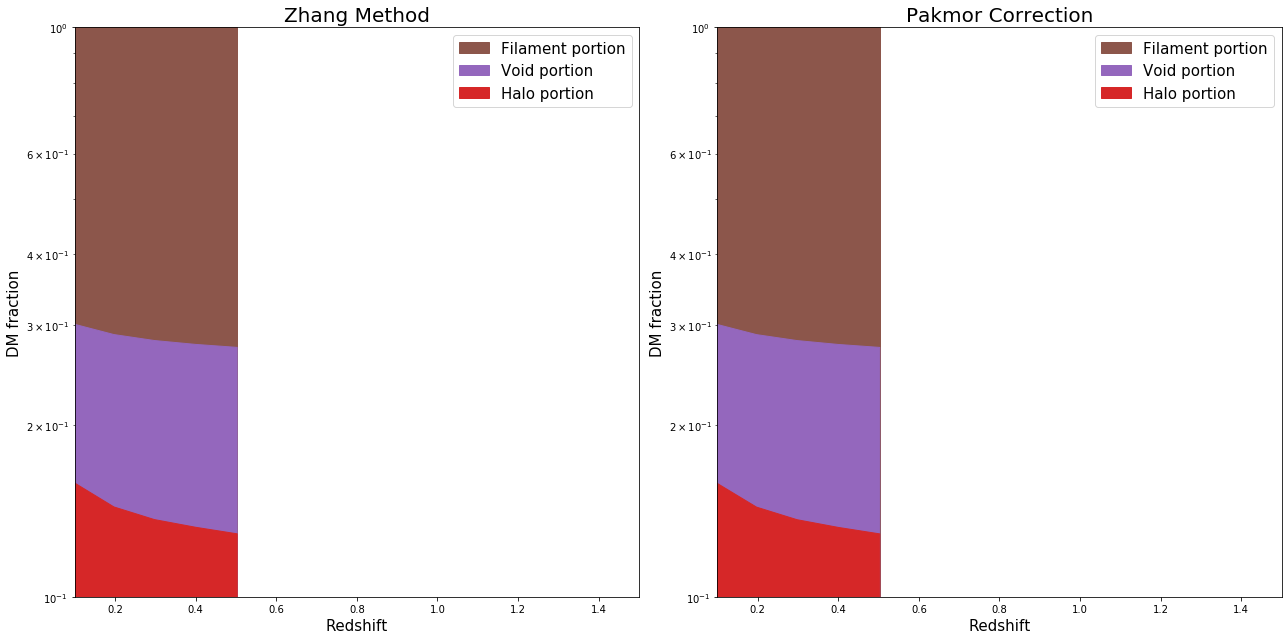

In [18]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(18,9))

ax1 = fig.add_subplot(121)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM fraction',fontsize=15)
ax1.set_yscale('log')
ax1.set_xlim([0.1,1.5])
ax1.set_ylim([1e-1,1.])

ax2 = fig.add_subplot(122)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM fraction',fontsize=15)
ax2.set_yscale('log')
ax2.set_xlim([0.1,1.5])
ax2.set_ylim([1e-1,1.])

######
#plot#
######

ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Zhang+mean_Voi_cDM_arr_Zhang+mean_Fil_cDM_arr_Zhang)/mean_cDM_arr_Zhang[:]),color='C5',alpha=1,ls='-',label='Filament portion')
ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Zhang+mean_Voi_cDM_arr_Zhang)/mean_cDM_arr_Zhang[:]),color='C4',alpha=1,ls='-',label='Void portion')
ax1.fill_between(snap_z_list,(mean_Hal_cDM_arr_Zhang)/mean_cDM_arr_Zhang[:],color='C3',alpha=1,ls='-',label='Halo portion')
ax1.legend(fontsize=15)

ax2.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor+mean_Fil_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),color='C5',alpha=1,ls='-',label='Filament portion')
ax2.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),color='C4',alpha=1,ls='-',label='Void portion')
ax2.fill_between(snap_z_list,(mean_Hal_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],color='C3',alpha=1,ls='-',label='Halo portion')
ax2.legend(fontsize=15)

plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics_2.png'.format(sim_to_load),format='png')
plt.show()

# Histograms of results 

In [19]:
######################
#do the histogramming#
######################

bin_edges = np.logspace(0,4,num=500) #set bins for histogramming

#total DMs
counts_Zhang  = np.apply_along_axis(hist_1d, 1, cDM_arr_Zhang.value,bin_edges)
counts_Pakmor = np.apply_along_axis(hist_1d, 1, cDM_arr_Pakmor.value,bin_edges)

#of which halos
Hal_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr_Zhang.value,bin_edges)
Hal_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr_Pakmor.value,bin_edges)

#of which filaments
Fil_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr_Zhang.value,bin_edges)
Fil_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr_Pakmor.value,bin_edges)

#of which voids
Voi_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr_Zhang.value,bin_edges)
Voi_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr_Pakmor.value,bin_edges)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [130]:
print(counts_Zhang.shape,counts_Pakmor.shape)
print(bin_edges.shape)

(12, 499) (12, 499)
(500,)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
Saving LSS_Analysis_Hists_TNG100-2.png


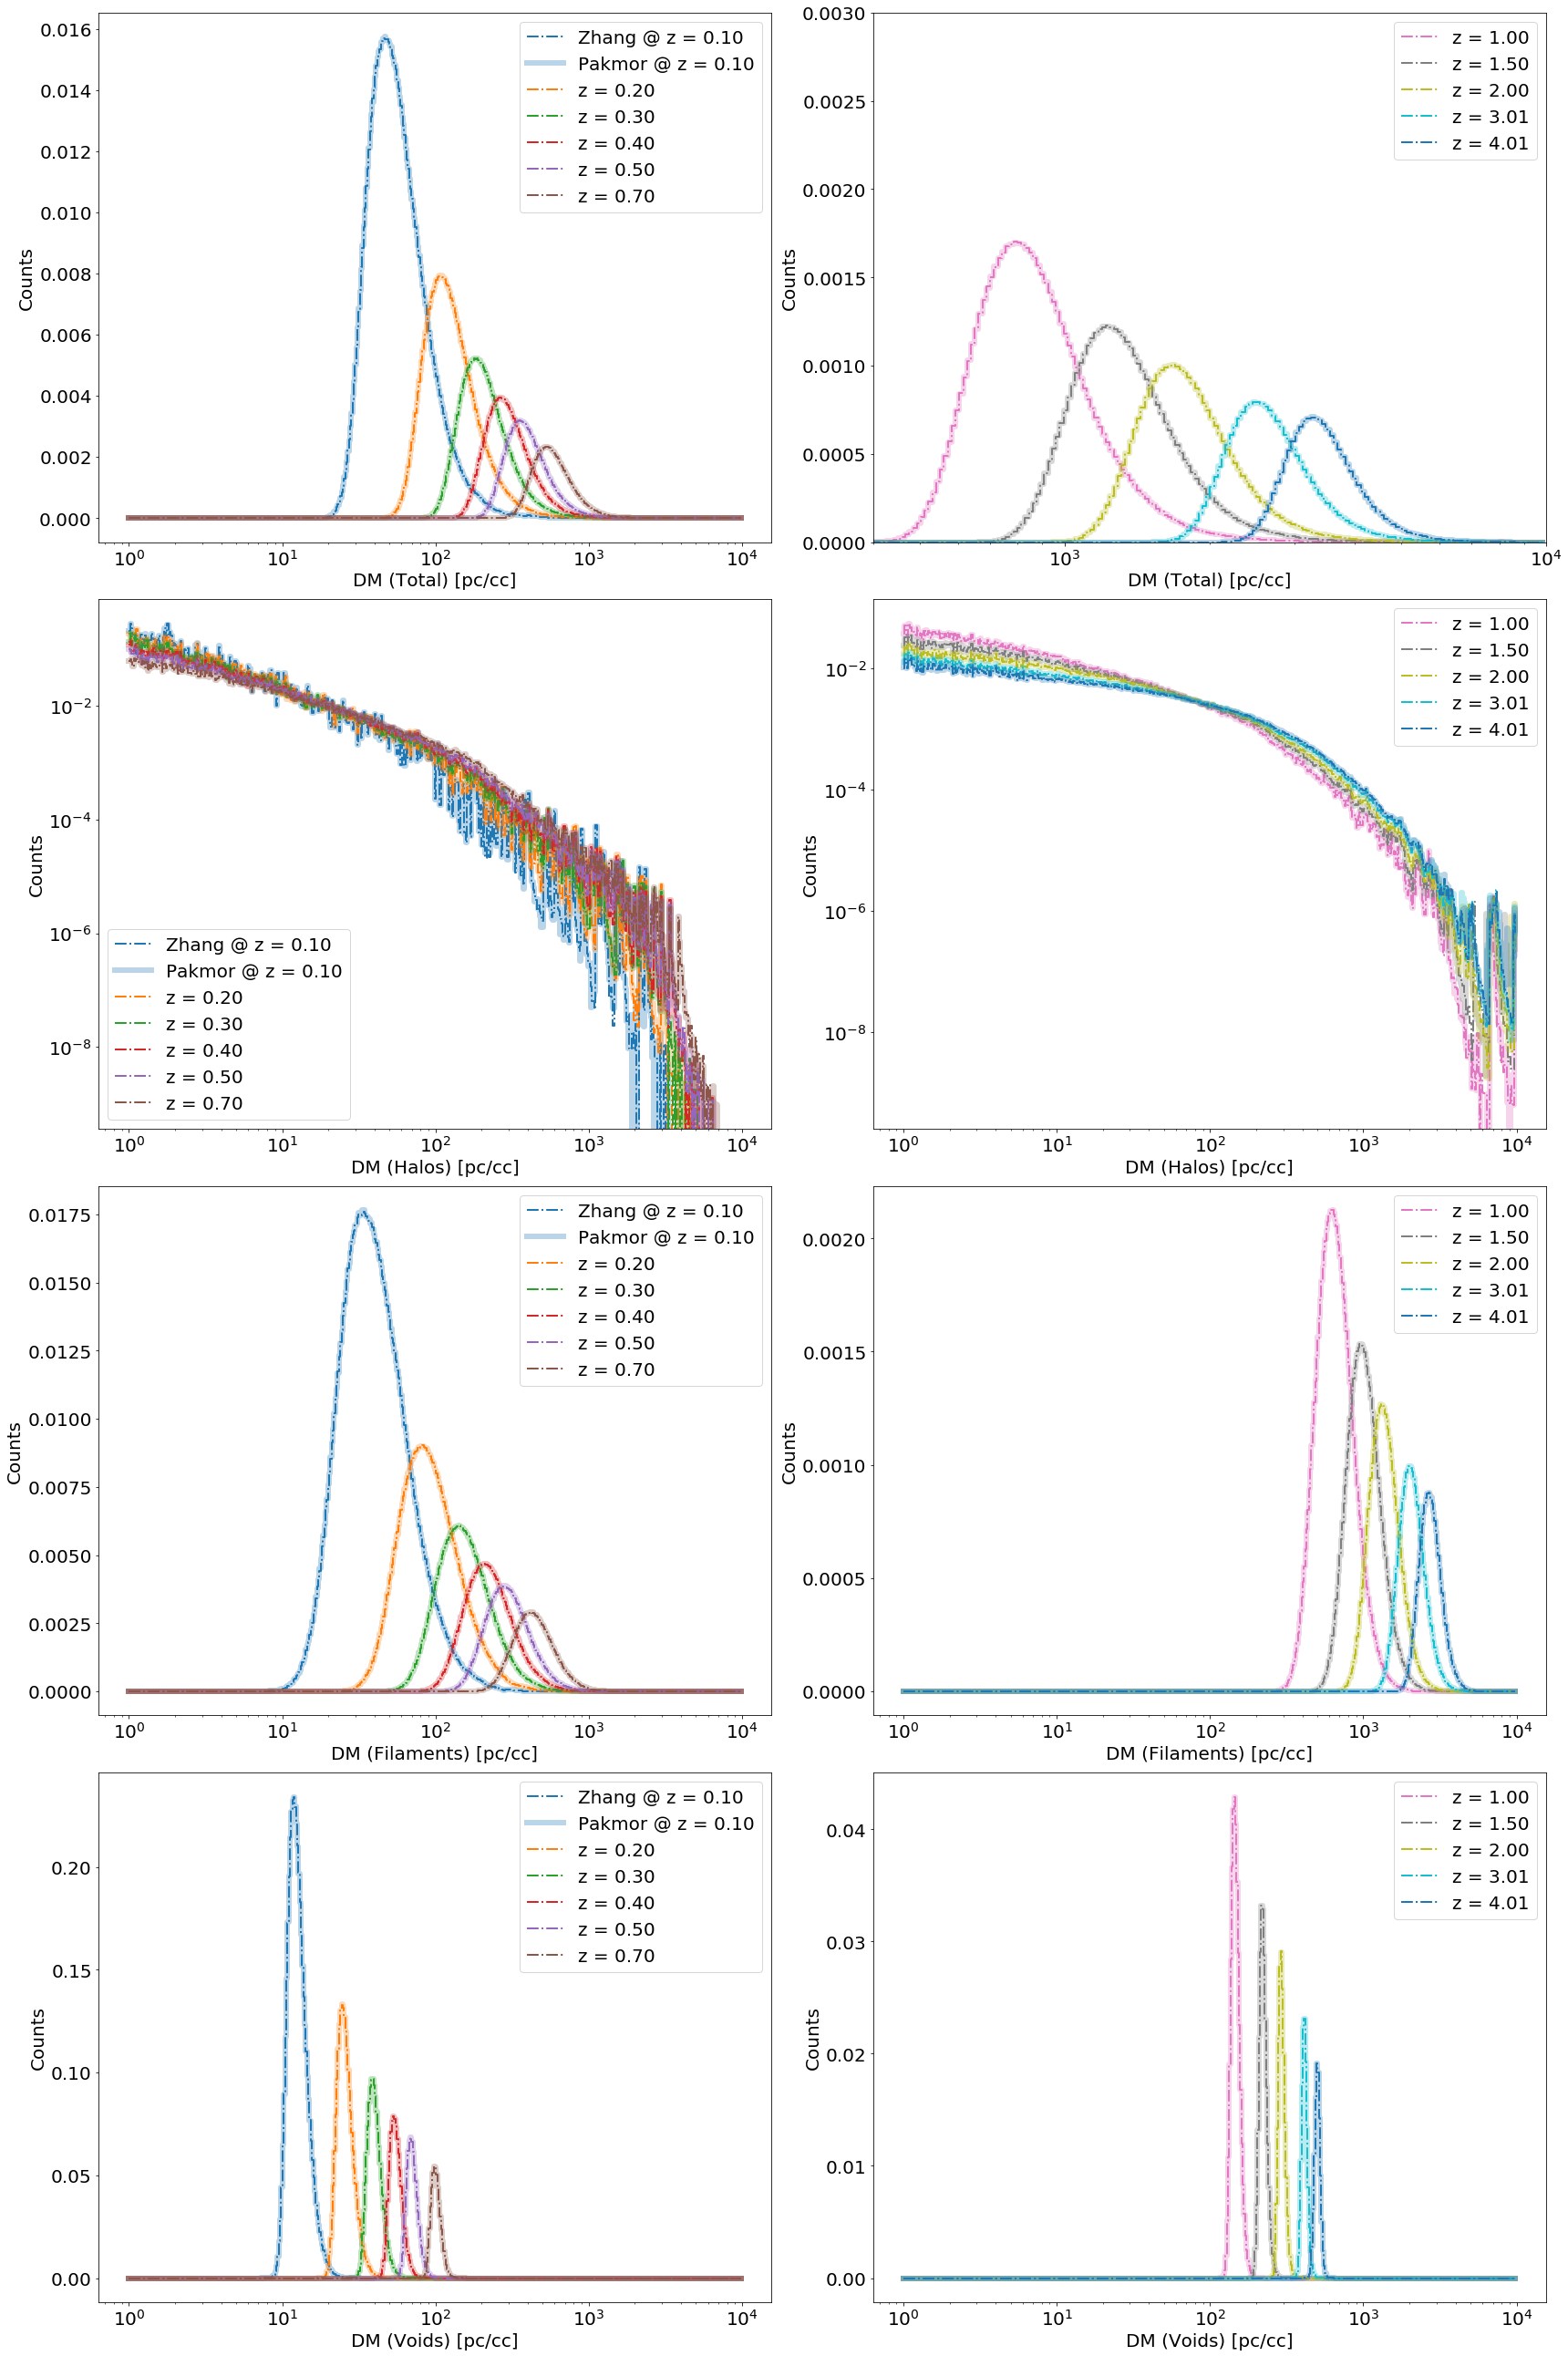

In [131]:
#histogram method from: https://stackoverflow.com/questions/64616617/matplotlib-plot-histogram-given-pre-computed-counts-and-bins

###################
#Initialise figure#
###################

fig = plt.figure(figsize=(24,36))

ax1 = fig.add_subplot(421)
ax1.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(422)
ax2.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax3 = fig.add_subplot(423)
ax3.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax3.set_ylabel('Counts',fontsize=20)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

ax4 = fig.add_subplot(424)
ax4.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax4.set_ylabel('Counts',fontsize=20)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax5 = fig.add_subplot(425)
ax5.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax5.set_ylabel('Counts',fontsize=20)
ax5.set_xscale('log')
ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)

ax6 = fig.add_subplot(426)
ax6.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax6.set_ylabel('Counts',fontsize=20)
ax6.set_xscale('log')
ax6.tick_params(axis='x', labelsize=20)
ax6.tick_params(axis='y', labelsize=20)

ax7 = fig.add_subplot(427)
ax7.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax7.set_ylabel('Counts',fontsize=20)
ax7.set_xscale('log')
ax7.tick_params(axis='x', labelsize=20)
ax7.tick_params(axis='y', labelsize=20)

ax8 = fig.add_subplot(428)
ax8.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax8.set_ylabel('Counts',fontsize=20)
ax8.set_xscale('log')
ax8.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)

#############
#Plot Totals#
#############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    if i==1:
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.step(x=bin_edges[:-1], y=counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax2.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1))

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)
    
############
#Plot Halos#
############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    if i==1:
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.', color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))        
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))        
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=0.3, lw=6,color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax4.step(x=bin_edges[:-1], y=Hal_counts_Zhang[i], where='post',  alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax4.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post',  alpha=0.3, lw=6, color='C{0}'.format(i-1))

    ax3.legend(fontsize=20)
    ax4.legend(fontsize=20)
    
################
#Plot Filaments#
################

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Zhang[i], where='post', ls='-.',lw=2, alpha=1, color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post',lw=6, alpha=0.3, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax6.step(x=bin_edges[:-1], y=Fil_counts_Zhang[i], where='post', ls='-.',lw=2, alpha=1, color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax6.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', lw=6, alpha=0.3, color='C{0}'.format(i-1))
        
    ax5.legend(fontsize=20)
    ax6.legend(fontsize=20)

############
#Plot Voids#
############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax8.step(x=bin_edges[:-1], y=Voi_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax8.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1))
    ax7.legend(fontsize=20)
    ax8.legend(fontsize=20)

plt.tight_layout()
print('Saving LSS_Analysis_Hists_{0}.png'.format(sim_to_load))
plt.savefig('LSS_Analysis_Hists_{0}.png'.format(sim_to_load),format='png')
plt.show()

# Plot the fits from Zhang+20

In [132]:
############
#Initialise#
############

xarr = np.linspace(0,10000,10000)

alpha=3
beta=3
A = np.array([0.04721,
              0.005693,
              0.003584,
              0.002876,
              0.002423,
              0.001880,
              0.001456,
              0.001098,
              0.0009672,
              0.0008968,
              0.0008826]) #from Zhang+20 table 1
C0 = np.array([-13.17,
               -1.008,
               0.596,
               1.010,
               1.127,
               1.170,
               1.189,
               1.163,
               1.162,
               1.119,
               1.092]) #from Zhang+20 table 1
sigmaDM = np.array([2.554,
                    1.118,
                    0.7043,
                    0.5158,
                    0.4306,
                    0.3595,
                    0.3044,
                    0.2609,
                    0.2160,
                    0.1566,
                    0.1233]) #from Zhang+20 table 1

##############
#Create delta#
##############

#Note: I was unsure what <DMIGM> should go into the data so I did two tests below:

#Test 1: <DMIGM> is the mean of my DM IGM values
#Test 2: <DMIGM> is the value from the macquart relation (i.e. <DMcosm)

########
#Test 1#
########

Delta_mydata_Zhang  = np.array([xarr/i for i in mean_cDM_arr_Zhang[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the mean of my data
Delta_mydata_Pakmor = np.array([xarr/i for i in mean_cDM_arr_Pakmor[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the mean of my data

########
#Test 2#
########

Delta_macq = np.array([xarr/i for i in np.array(cosm_theory_2)[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the macquart relation

print('my data shape:{0}'.format(Delta_mydata_Zhang.shape))
print('macquart data shape:  {0}'.format(Delta_macq.shape))
print('A shape: {0}'.format(A.shape))
print('sigma DM shape: {0}'.format(sigmaDM.shape))
print('C0 shape: {0}'.format(C0.shape))

####################################
#create the P curves for each Delta#
####################################

########
#Test 1#
########

P_mydata_Zhang  = (A[:,None]*(Delta_mydata_Zhang)**(-1*beta))*np.exp(-1*((((Delta_mydata_Zhang**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))
P_mydata_Pakmor = (A[:,None]*(Delta_mydata_Pakmor)**(-1*beta))*np.exp(-1*((((Delta_mydata_Pakmor**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))

########
#Test 2#
########

P_macq=(A[:,None]*(Delta_macq)**(-1*beta))*np.exp(-1*((((Delta_macq**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))



my data shape:(11, 10000)
macquart data shape:  (11, 10000)
A shape: (11,)
sigma DM shape: (11,)
C0 shape: (11,)


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in multiply


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


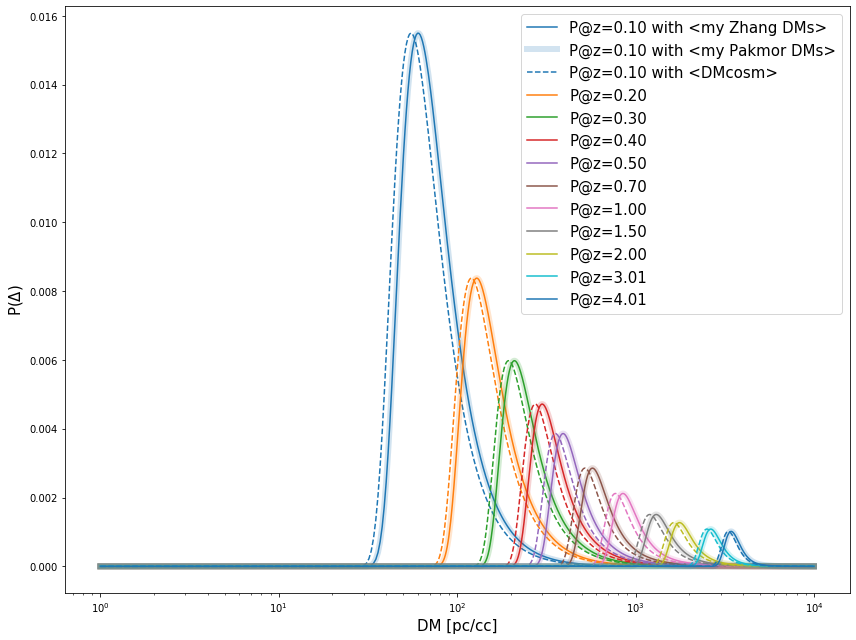

In [133]:
######
#plot#
######

#################
#Initialise plot#
#################
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('DM [pc/cc]',fontsize=15)
ax.set_ylabel('P($\Delta$)',fontsize=15)
ax.set_xscale('log')


#################
#plot the curves#
#################

for i in range(P_mydata_Zhang.shape[0]):
    if i==0:
        ax.plot(xarr,P_mydata_Zhang[i],color='C{0}'.format(i),label='P@z={0:.2f} with <my Zhang DMs>'.format(snap_z_list[1:][i]))
        ax.plot(xarr,P_mydata_Pakmor[i],color='C{0}'.format(i), linewidth=6, alpha=0.2, label='P@z={0:.2f} with <my Pakmor DMs>'.format(snap_z_list[1:][i]))
        ax.plot(xarr,P_macq[i],ls='--',color='C{0}'.format(i),label='P@z={0:.2f} with <DMcosm>'.format(snap_z_list[1:][i]))
    elif i>0:
        ax.plot(xarr,P_mydata_Zhang[i],color='C{0}'.format(i),label='P@z={0:.2f}'.format(snap_z_list[1:][i]))
        ax.plot(xarr,P_mydata_Pakmor[i],color='C{0}'.format(i),lw=6,alpha=0.2)
        ax.plot(xarr,P_macq[i],ls='--',color='C{0}'.format(i))

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Zhang_Fits.png'.format(sim_to_load),format='png')
plt.show()
#print(Delta)

Result: Unsure which mean to use. This should be discussed with Laura as our values are actually different to Zhangs, and so these curves might also differ...

# Overplot the fits on the histograms

No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191


No handles with labels found to put in legend.


2 0.19728418237600986


No handles with labels found to put in legend.


3 0.2977176845174465


No handles with labels found to put in legend.


4 0.3999269646135635


No handles with labels found to put in legend.


5 0.5030475232448832


No handles with labels found to put in legend.


6 0.7001063537185233


No handles with labels found to put in legend.


7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


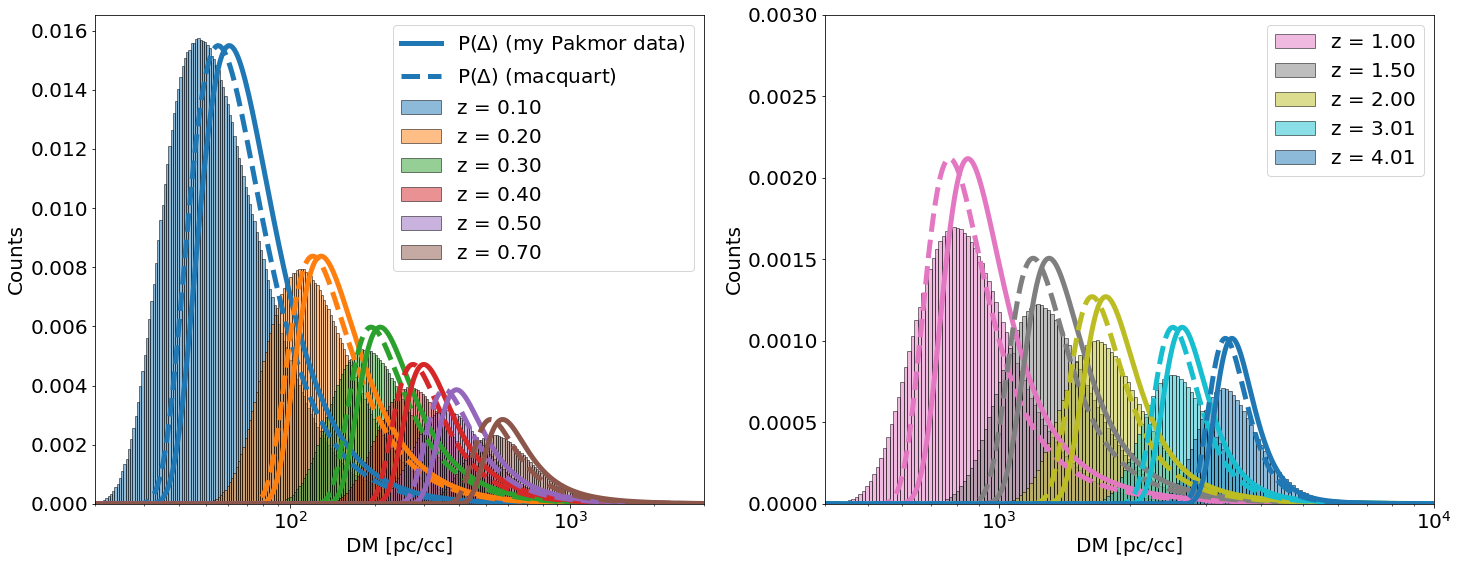

In [134]:
##################
#Initialise plots#
##################

fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.set_xlim([2e1,3e3])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(122)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

######################
#Perform the plotting#
######################

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts_Pakmor[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata_Pakmor[i-1],color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (my Pakmor data)')
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (macquart)')
        
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts_Pakmor[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata_Pakmor[i-1],color='C{0}'.format(i-1),lw=5)
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts_Pakmor[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax2.plot(xarr,P_mydata_Pakmor[i-1],color='C{0}'.format(i-1),lw=5)
        ax2.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)

plt.tight_layout
plt.savefig('{0}_Zhang_Fit_Data_Comparisons.png'.format(sim_to_load),format='png')
plt.show()


# Plot histograms in 2d

(12, 499)
(500,)
(12,)
0.0 0.28562509785296164


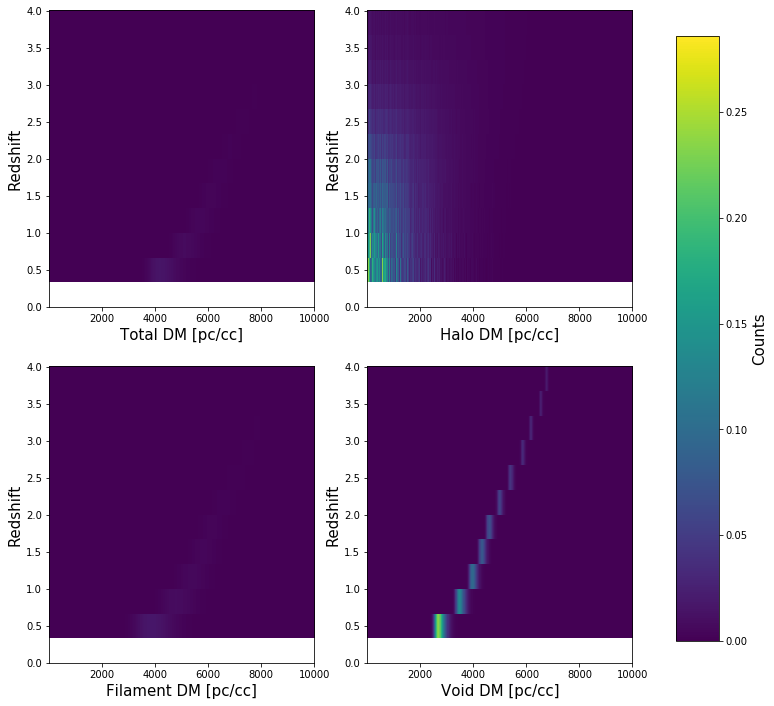

In [135]:
#original data
print(counts_Pakmor.shape) # the histograms
print(bin_edges.shape) # the edges of the bins of these histograms
print(np.array(snap_z_list).shape) # the redshifts these snapshots were taken at

#initialise figure
fig=plt.figure(figsize=(12,12))

ax1=fig.add_subplot(221)
ax1.set_ylabel('Redshift',fontsize=15)
ax1.set_xlabel('Total DM [pc/cc]',fontsize=15)

ax2=fig.add_subplot(222)
ax2.set_ylabel('Redshift',fontsize=15)
ax2.set_xlabel('Halo DM [pc/cc]',fontsize=15)

ax3=fig.add_subplot(223)
ax3.set_ylabel('Redshift',fontsize=15)
ax3.set_xlabel('Filament DM [pc/cc]',fontsize=15)

ax4=fig.add_subplot(224)
ax4.set_ylabel('Redshift',fontsize=15)
ax4.set_xlabel('Void DM [pc/cc]',fontsize=15)

#extent of the x,y axis
extent = [bin_edges[0],bin_edges[-1],snap_z_list[0],snap_z_list[-1]] 

# find minimum of minima & maximum of maxima for consistent colorbar across subplots
minmin = np.min([np.nanmin(counts_Pakmor),
                 np.nanmin(Hal_counts_Pakmor),
                 np.nanmin(Fil_counts_Pakmor),
                 np.nanmin(Voi_counts_Pakmor)])

maxmax = np.max([np.nanmax(counts_Pakmor),
                 np.nanmax(Hal_counts_Pakmor),
                 np.nanmax(Fil_counts_Pakmor),
                 np.nanmax(Voi_counts_Pakmor)])
print(minmin,maxmax)

im1 = ax1.imshow(counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)
im2 = ax2.imshow(Hal_counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)
im3 = ax3.imshow(Fil_counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)
im4 = ax4.imshow(Voi_counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts',fontsize=15)

plt.tight_layout
plt.savefig('{0}_Zhang_Data_2D.png'.format(sim_to_load),format='png')
plt.show()


# Plot the other axis

(12, 499)
(499,)
(12,)


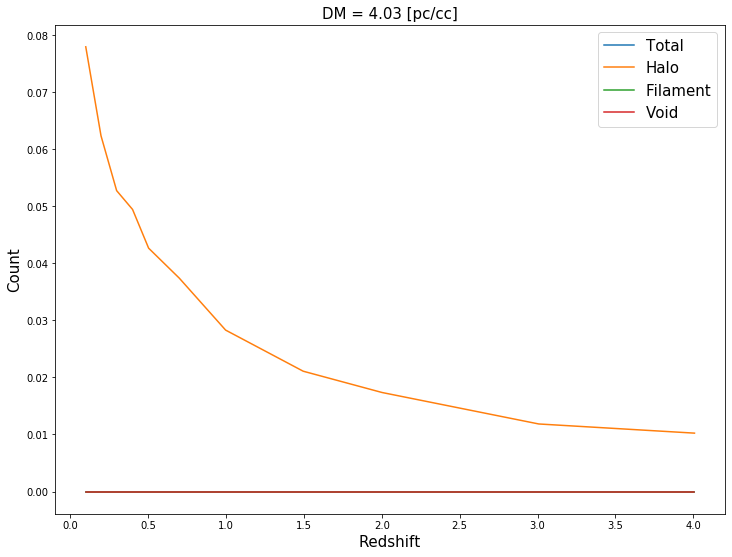

In [136]:
print(counts_Pakmor.shape)
print(counts_Pakmor[0].shape)
print(counts_Pakmor[:,0].shape)


fig = plt.figure(figsize=(12,9))
ax=fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('Count',fontsize=15)


for i in range(counts_Pakmor.shape[1]):
    
    
    if i==75:
        ax.set_title('DM = {0:.2f} [pc/cc]'.format((bin_edges[i]+bin_edges[i+1])/2),fontsize=15)

        ax.plot(snap_z_list,counts_Pakmor[:,i],label='Total')
        ax.plot(snap_z_list,Hal_counts_Pakmor[:,i],label='Halo')
        ax.plot(snap_z_list,Fil_counts_Pakmor[:,i],label='Filament')
        ax.plot(snap_z_list,Voi_counts_Pakmor[:,i],label='Void')

plt.legend(fontsize=15)   
plt.show()



# Fitting to LSS histograms

# Voids

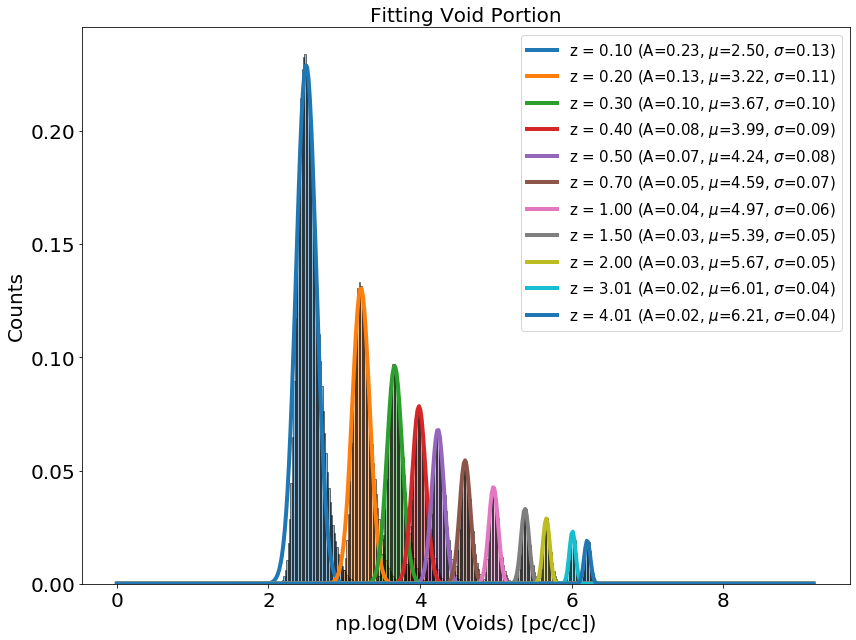

In [137]:
#initialise figure
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax1.set_title('Fitting Void Portion',fontsize=20)
ax1.set_xlabel('np.log(DM (Voids) [pc/cc])',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
#ax1.set_xscale('log')
#ax1.set_xlim([0,1000])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)): #loop over redshifts
    
    #####################
    #extract data to fit#
    #####################
    
    x=np.log(bin_edges[:-1]) #x values of histograms (log to preserve gaussian shape)
    #x=bin_edges[:-1] #x values of histograms (log to preserve gaussian shape)
    #y=Hal_counts_Pakmor[i] #halo portion
    #y=Fil_counts_Pakmor[i] #filament portion
    y=Voi_counts_Pakmor[i] #void portions
    

    ######################################
    #only fit for snapshot 91 and onwards#
    ######################################
    
    if i>=1:
        
        ###########################################
        #guess initial parameters for gaussian fit#
        ###########################################
        
        amp = y[np.argmax(y)] #guess amplitude of curve: height of largest bin
        mean = x[np.argmax(y)] #guess mean: DM of largest bin
        stddev=1
        
        #####################
        #Perform the fitting#
        #####################
        
        g_init = models.Gaussian1D(amplitude=amp, mean=mean, stddev=stddev)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, x, y)
        
        ##############
        #plot the fit#
        ##############
        
        ax1.bar(x=x,height=y,width=np.diff(np.log(bin_edges)), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1))
        ax1.plot(x, g(x), color='C{0}'.format(i-1),lw=4,label='z = {0:.2f} (A={1:.2f}, $\mu$={2:.2f}, $\sigma$={3:.2f})'.format(snap_z_list[i],g.amplitude.value,g.mean.value,g.stddev.value))
        
        plt.legend(fontsize=15)
        
plt.tight_layout()
plt.savefig('LSS_Fits_Void_Gaussian.png',format='png')
    


# Filaments

1 3.5254008237423866 0.017657848802573744
2 4.374450236790291 0.009000111079931303
3 4.946635710800836 0.006076958140786516
4 5.334245225453139 0.004684896523294557
5 5.629566760426323 0.0038791312549660384
6 6.017176275078628 0.0029184216359296918
7 6.44170098160258 0.002124081735370874
8 6.866225688126533 0.001536098853694742
9 7.161547223099716 0.0012682534866992382
10 7.604529525559493 0.0009963826998794511
11 7.8813934645968535 0.0008784815274531616


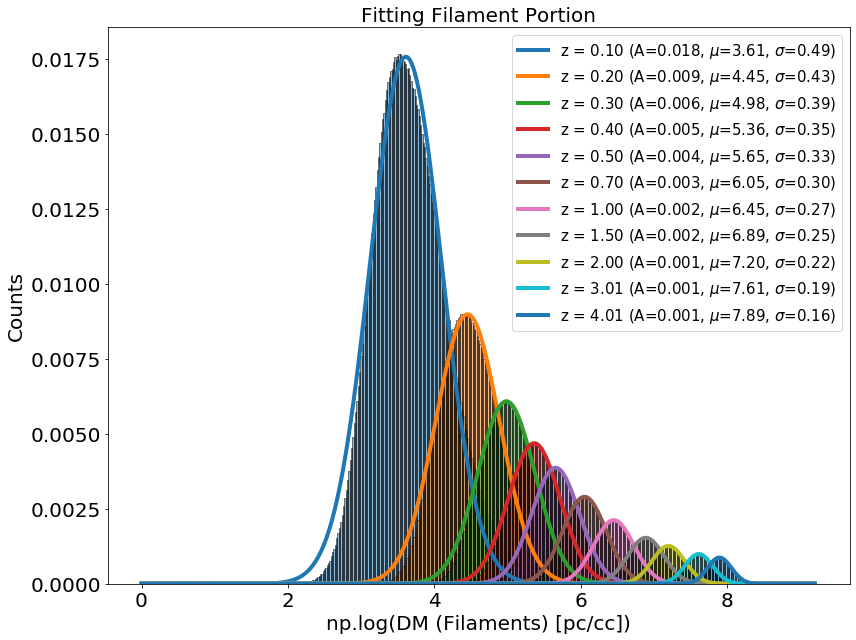

In [140]:
#initialise figure
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax1.set_title('Fitting Filament Portion',fontsize=20)
ax1.set_xlabel('np.log(DM (Filaments) [pc/cc])',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
#ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)): #loop over redshifts
    
    #####################
    #extract data to fit#
    #####################
    
    x=np.log(bin_edges[:-1]) #x values of histograms (log to preserve gaussian shape)
    #x=bin_edges[:-1] #x values of histograms
    #y=Hal_counts_Pakmor[i] #halo portion
    y=Fil_counts_Pakmor[i] #filament portion
    #y=Voi_counts_Pakmor[i] #void portions
    

    ######################################
    #only fit for snapshot 91 and onwards#
    ######################################
    
    if i>=1:
        
        ###########################################
        #guess initial parameters for gaussian fit#
        ###########################################
        
        amp = y[np.argmax(y)] #guess amplitude of curve: height of largest bin
        mean = x[np.argmax(y)] #guess mean: DM of largest bin
        print(i,mean,amp)
        stddev=1
        
        #####################
        #Perform the fitting#
        #####################
        
        g_init = models.Gaussian1D(amplitude=amp, mean=mean, stddev=stddev)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, x, y)
        
        ##############
        #plot the fit#
        ##############
        
        #ax1.scatter(x,y)
        ax1.bar(x=x,height=y,width=np.diff(np.log(bin_edges)), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1))
        ax1.plot(x, g(x), color='C{0}'.format(i-1),lw=4,label='z = {0:.2f} (A={1:.3f}, $\mu$={2:.2f}, $\sigma$={3:.2f})'.format(snap_z_list[i],g.amplitude.value,g.mean.value,g.stddev.value))
        
        plt.legend(fontsize=15)
        
plt.tight_layout()
plt.savefig('LSS_Fits_Filament_Gaussian.png',format='png')